# PHASE 0: PRE-SETUP

### ✅ Setup Checklist (run before training)
- ☐ GPU runtime selected (Runtime → Change runtime type → GPU)
- ☐ Google Drive mounted
- ☐ Checkpoint & log directories exist in Drive
- ☐ Keep-alive script executed
- ☐ Dataset downloaded & verified

> Tip: mark each box in your head (or add `☑`) once complete to avoid missed steps.


In [1]:
%%javascript
function ClickConnect(){
  console.log('Keeping Colab alive...');
  const connectBtn = document.querySelector('#top-toolbar > colab-connect-button');
  if (connectBtn) {
    const shadowRoot = connectBtn.shadowRoot;
    if (shadowRoot) {
      const btn = shadowRoot.querySelector('#connect');
      if (btn) {
        btn.click();
      }
    }
  }
}
setInterval(ClickConnect, 60000);
console.log('✅ Keep-alive script running (clicks connect every 60s)');


<IPython.core.display.Javascript object>

### 🆘 Recovery Instructions
1. **After crash/disconnect**
   - Reconnect notebook & rerun Section 1 setup cells
   - Confirm `training_progress.json` exists inside Drive checkpoints folder
   - Run the crash-proof training cell; it auto-loads the latest checkpoint and resumes
2. **Inspect current progress**
   - Open `training_progress.json` to view last completed epoch & metrics
   - Check `training_history.csv` in Drive logs for per-epoch stats
   - Review `training_log.txt` for detailed timeline & warnings
3. **Manual checkpoint loading**
   - Use `load_model_safe()` (Section 6) to load `best_model.h5` or the most recent epoch file
   - To resume mid-training manually: `model = keras.models.load_model(<path_to_checkpoint>)` then rerun the training cell
4. **Verifying safety**
   - Run the `verify_setup()` helper; all checks must be green before launching long jobs


In [2]:
# 📁 Section 1: Environment Setup (≈2 minutes)
%pip install -q kagglehub gradio opencv-python-headless seaborn scikit-learn tqdm psutil GPUtil

  Preparing metadata (setup.py) ... done


In [3]:
# Core imports & global configuration (≈3 minutes to run)
import os
import sys
import json
import math
import time
import gc
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import psutil
import GPUtil
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (ModelCheckpoint, EarlyStopping,
                                        ReduceLROnPlateau, CSVLogger, LambdaCallback)
from tensorflow.keras.models import load_model

# Detect Colab & mount Drive for persistence
try:
    import google.colab  # type: ignore
    IN_COLAB = True
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    BASE_PATH = Path('/content')
    DRIVE_ROOT = Path('/content/drive/MyDrive')
    print("✅ Google Colab environment detected")
except Exception:
    IN_COLAB = False
    BASE_PATH = Path.cwd()
    DRIVE_ROOT = BASE_PATH / 'colab_emulation'
    DRIVE_ROOT.mkdir(parents=True, exist_ok=True)
    print("⚠️ Running outside Colab. Using local 'colab_emulation' folder for persistence.")

# Persistent directories
CHECKPOINT_DIR = DRIVE_ROOT / 'plant_disease_checkpoints'
LOG_DIR = DRIVE_ROOT / 'plant_disease_logs'
ARTIFACT_DIR = DRIVE_ROOT / 'plant_disease_artifacts'
for directory in [CHECKPOINT_DIR, LOG_DIR, ARTIFACT_DIR]:
    directory.mkdir(parents=True, exist_ok=True)

BEST_MODEL_PATH = CHECKPOINT_DIR / 'best_model.h5'
HISTORY_CSV_PATH = LOG_DIR / 'training_history.csv'
PROGRESS_JSON_PATH = LOG_DIR / 'training_progress.json'
TRAINING_LOG_PATH = LOG_DIR / 'training_log.txt'

print(f"📁 Checkpoints: {CHECKPOINT_DIR}")
print(f"🗂️ Logs:        {LOG_DIR}")
print(f"🧪 Artifacts:   {ARTIFACT_DIR}")

# Helper utilities -----------------------------------------------------------
def log_event(message: str, also_print: bool = True):
    """Write timestamped message to training log and optionally stdout."""
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    entry = f"[{timestamp}] {message}"
    if also_print:
        print(entry)
    with open(TRAINING_LOG_PATH, 'a', encoding='utf-8') as log_file:
        log_file.write(entry + '\n')


def format_eta(seconds: float) -> str:
    if seconds <= 0:
        return '0m'
    mins, _ = divmod(int(seconds), 60)
    hours, mins = divmod(mins, 60)
    return f"{hours}h {mins}m" if hours else f"{mins}m"


def append_history_csv(epoch: int, logs: dict, timestamp: datetime):
    """Append a single row to training_history.csv (never overwritten)."""
    row = {
        'epoch': epoch + 1,
        'loss': logs.get('loss'),
        'accuracy': logs.get('accuracy'),
        'val_loss': logs.get('val_loss'),
        'val_accuracy': logs.get('val_accuracy'),
        'timestamp': timestamp.isoformat()
    }
    header_needed = not HISTORY_CSV_PATH.exists()
    df = pd.DataFrame([row])
    df.to_csv(HISTORY_CSV_PATH, mode='a', header=header_needed, index=False)


def save_progress(epoch: int, history: list, checkpoint_path: str):
    progress = {
        'last_completed_epoch': epoch + 1,
        'history': history,
        'last_checkpoint_path': checkpoint_path,
        'updated_at': datetime.now().isoformat()
    }
    with open(PROGRESS_JSON_PATH, 'w', encoding='utf-8') as f:
        json.dump(progress, f, indent=2)


def load_progress():
    if PROGRESS_JSON_PATH.exists():
        with open(PROGRESS_JSON_PATH, 'r', encoding='utf-8') as f:
            return json.load(f)
    return None


def get_gpu_report() -> str:
    gpus = GPUtil.getGPUs()
    if not gpus:
        return 'No GPU detected'
    gpu = gpus[0]
    return f"{gpu.name} | {gpu.memoryUsed:.1f}GB / {gpu.memoryTotal:.1f}GB"

# GPU verification -----------------------------------------------------------
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        log_event(f"GPU(s) detected: {len(gpus)} → memory growth enabled")
    except RuntimeError as err:
        log_event(f"GPU memory growth setting failed: {err}")
else:
    log_event("⚠️ No GPU detected. Switch runtime to GPU for best performance.")

print(f"🔋 GPU report: {get_gpu_report()}")
print(f"🧠 System RAM: {psutil.virtual_memory().total / 1e9:.2f} GB")

# Dataset download (cached) --------------------------------------------------
import kagglehub
DATASET_ID = "vipoooool/new-plant-diseases-dataset"
log_event(f"Downloading dataset: {DATASET_ID}")
DATASET_PATH = Path(kagglehub.dataset_download(DATASET_ID))
# Maintain legacy variable name so downstream cells keep working
dataset_path = DATASET_PATH
print(f"✅ Dataset ready at: {DATASET_PATH}")


Mounted at /content/drive
✅ Google Colab environment detected
📁 Checkpoints: /content/drive/MyDrive/plant_disease_checkpoints
🗂️ Logs:        /content/drive/MyDrive/plant_disease_logs
🧪 Artifacts:   /content/drive/MyDrive/plant_disease_artifacts
[2025-11-30 04:34:33] GPU(s) detected: 1 → memory growth enabled
🔋 GPU report: Tesla T4 | 2.0GB / 15360.0GB
🧠 System RAM: 13.61 GB
[2025-11-30 04:34:34] Downloading dataset: vipoooool/new-plant-diseases-dataset
Using Colab cache for faster access to the 'new-plant-diseases-dataset' dataset.
✅ Dataset ready at: /kaggle/input/new-plant-diseases-dataset


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
def verify_setup():
    """Sanity-check that all crash-recovery prerequisites exist."""
    checks = {
        '✓ Checkpoint directory exists': CHECKPOINT_DIR.exists(),
        '✓ Training history CSV exists': HISTORY_CSV_PATH.exists(),
        '✓ Progress JSON exists': PROGRESS_JSON_PATH.exists(),
        '✓ GPU available': len(tf.config.list_physical_devices('GPU')) > 0,
        '✓ Google Drive mounted': DRIVE_ROOT.exists()
    }
    for description, status in checks.items():
        print(f"{description}: {'✅' if status else '❌'}")
    return all(checks.values())

# Run verification for quick feedback
if verify_setup():
    print("\n🎉 All systems ready! Safe to start training.")
else:
    print("\n⚠️ Some checks failed. Please fix before training.")


✓ Checkpoint directory exists: ✅
✓ Training history CSV exists: ✅
✓ Progress JSON exists: ❌
✓ GPU available: ✅
✓ Google Drive mounted: ✅

⚠️ Some checks failed. Please fix before training.


# PHASE 1: ENVIRONMENT SETUP

In [6]:
# ===== CELL 1: GPU CHECK & INSTALLATIONS =====
import tensorflow as tf
import sys

print("=" * 60)
print("SYSTEM INFORMATION")
print("=" * 60)
print(f"Python Version: {sys.version}")
print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
print("=" * 60)

# Install required packages
!pip install -q kagglehub gradio opencv-python-headless seaborn scikit-learn

# ===== CELL 2: IMPORT LIBRARIES =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from datetime import datetime
from pathlib import Path

# TensorFlow/Keras imports
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model

# Sklearn imports
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")

# ===== CELL 3: DOWNLOAD DATASET =====
import kagglehub

print("Downloading PlantVillage Dataset...")
dataset_path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")
print(f"✅ Dataset downloaded to: {dataset_path}")

# Explore directory structure
for root, dirs, files in os.walk(dataset_path):
    level = root.replace(dataset_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    if level < 2:  # Only show first 2 levels
        subindent = ' ' * 2 * (level + 1)
        for file in files[:3]:  # Show first 3 files
            print(f'{subindent}{file}')
        if len(files) > 3:
            print(f'{subindent}... and {len(files)-3} more files')

SYSTEM INFORMATION
Python Version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
TensorFlow Version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ All libraries imported successfully!
Using Colab cache for faster access to the 'new-plant-diseases-dataset' dataset.
✅ Dataset downloaded to: /kaggle/input/new-plant-diseases-dataset
new-plant-diseases-dataset/
  New Plant Diseases Dataset(Augmented)/
    New Plant Diseases Dataset(Augmented)/
      valid/
        Tomato___Late_blight/
        Tomato___healthy/
        Grape___healthy/
        Orange___Haunglongbing_(Citrus_greening)/
        Soybean___healthy/
        Squash___Powdery_mildew/
        Potato___healthy/
        Corn_(maize)___Northern_Leaf_Blight/
        Tomato___Early_blight/
        Tomato___Septoria_leaf_spot/
        Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot/
        Strawberry___Leaf_scorch/
        Peach___healthy/
        Apple___Apple_scab/
        Tomato___

# PHASE 2: DATA EXPLORATION

Train Directory: /kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train
Validation Directory: /kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid

📊 Dataset Overview:
Number of Classes: 38
Class Names Sample: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy']...

📈 Image Distribution:
                                       Class  Training  Validation  Total
4                          Soybean___healthy      2022         505   2527
13                        Apple___Apple_scab      2016         504   2520
3   Orange___Haunglongbing_(Citrus_greening)      2010         503   2513
27                           Apple___healthy      2008         502   2510
22                    Pepper,_bell___healthy      1988         497   2485
16                         Apple___Black_rot      1987         497  

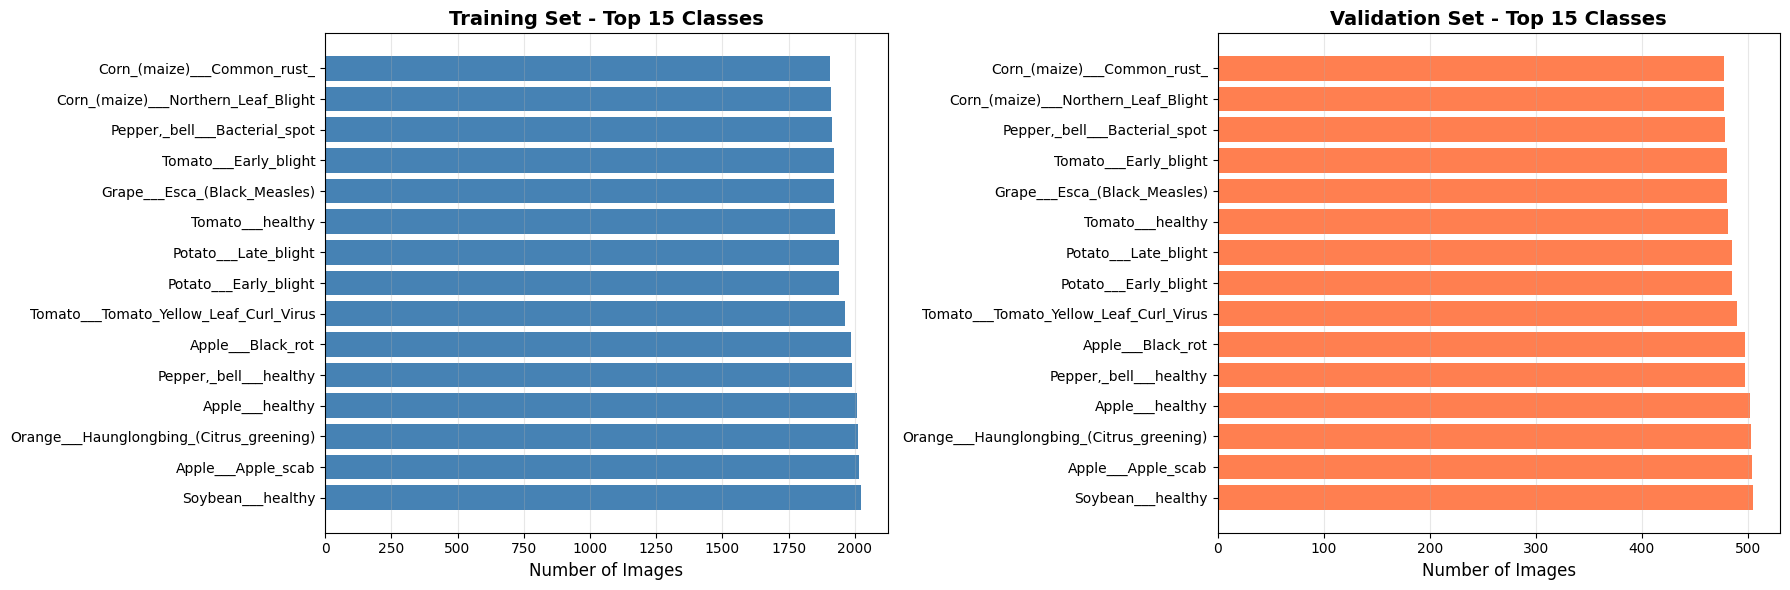

✅ Distribution chart saved as 'class_distribution.png'
Displaying sample images from training set...


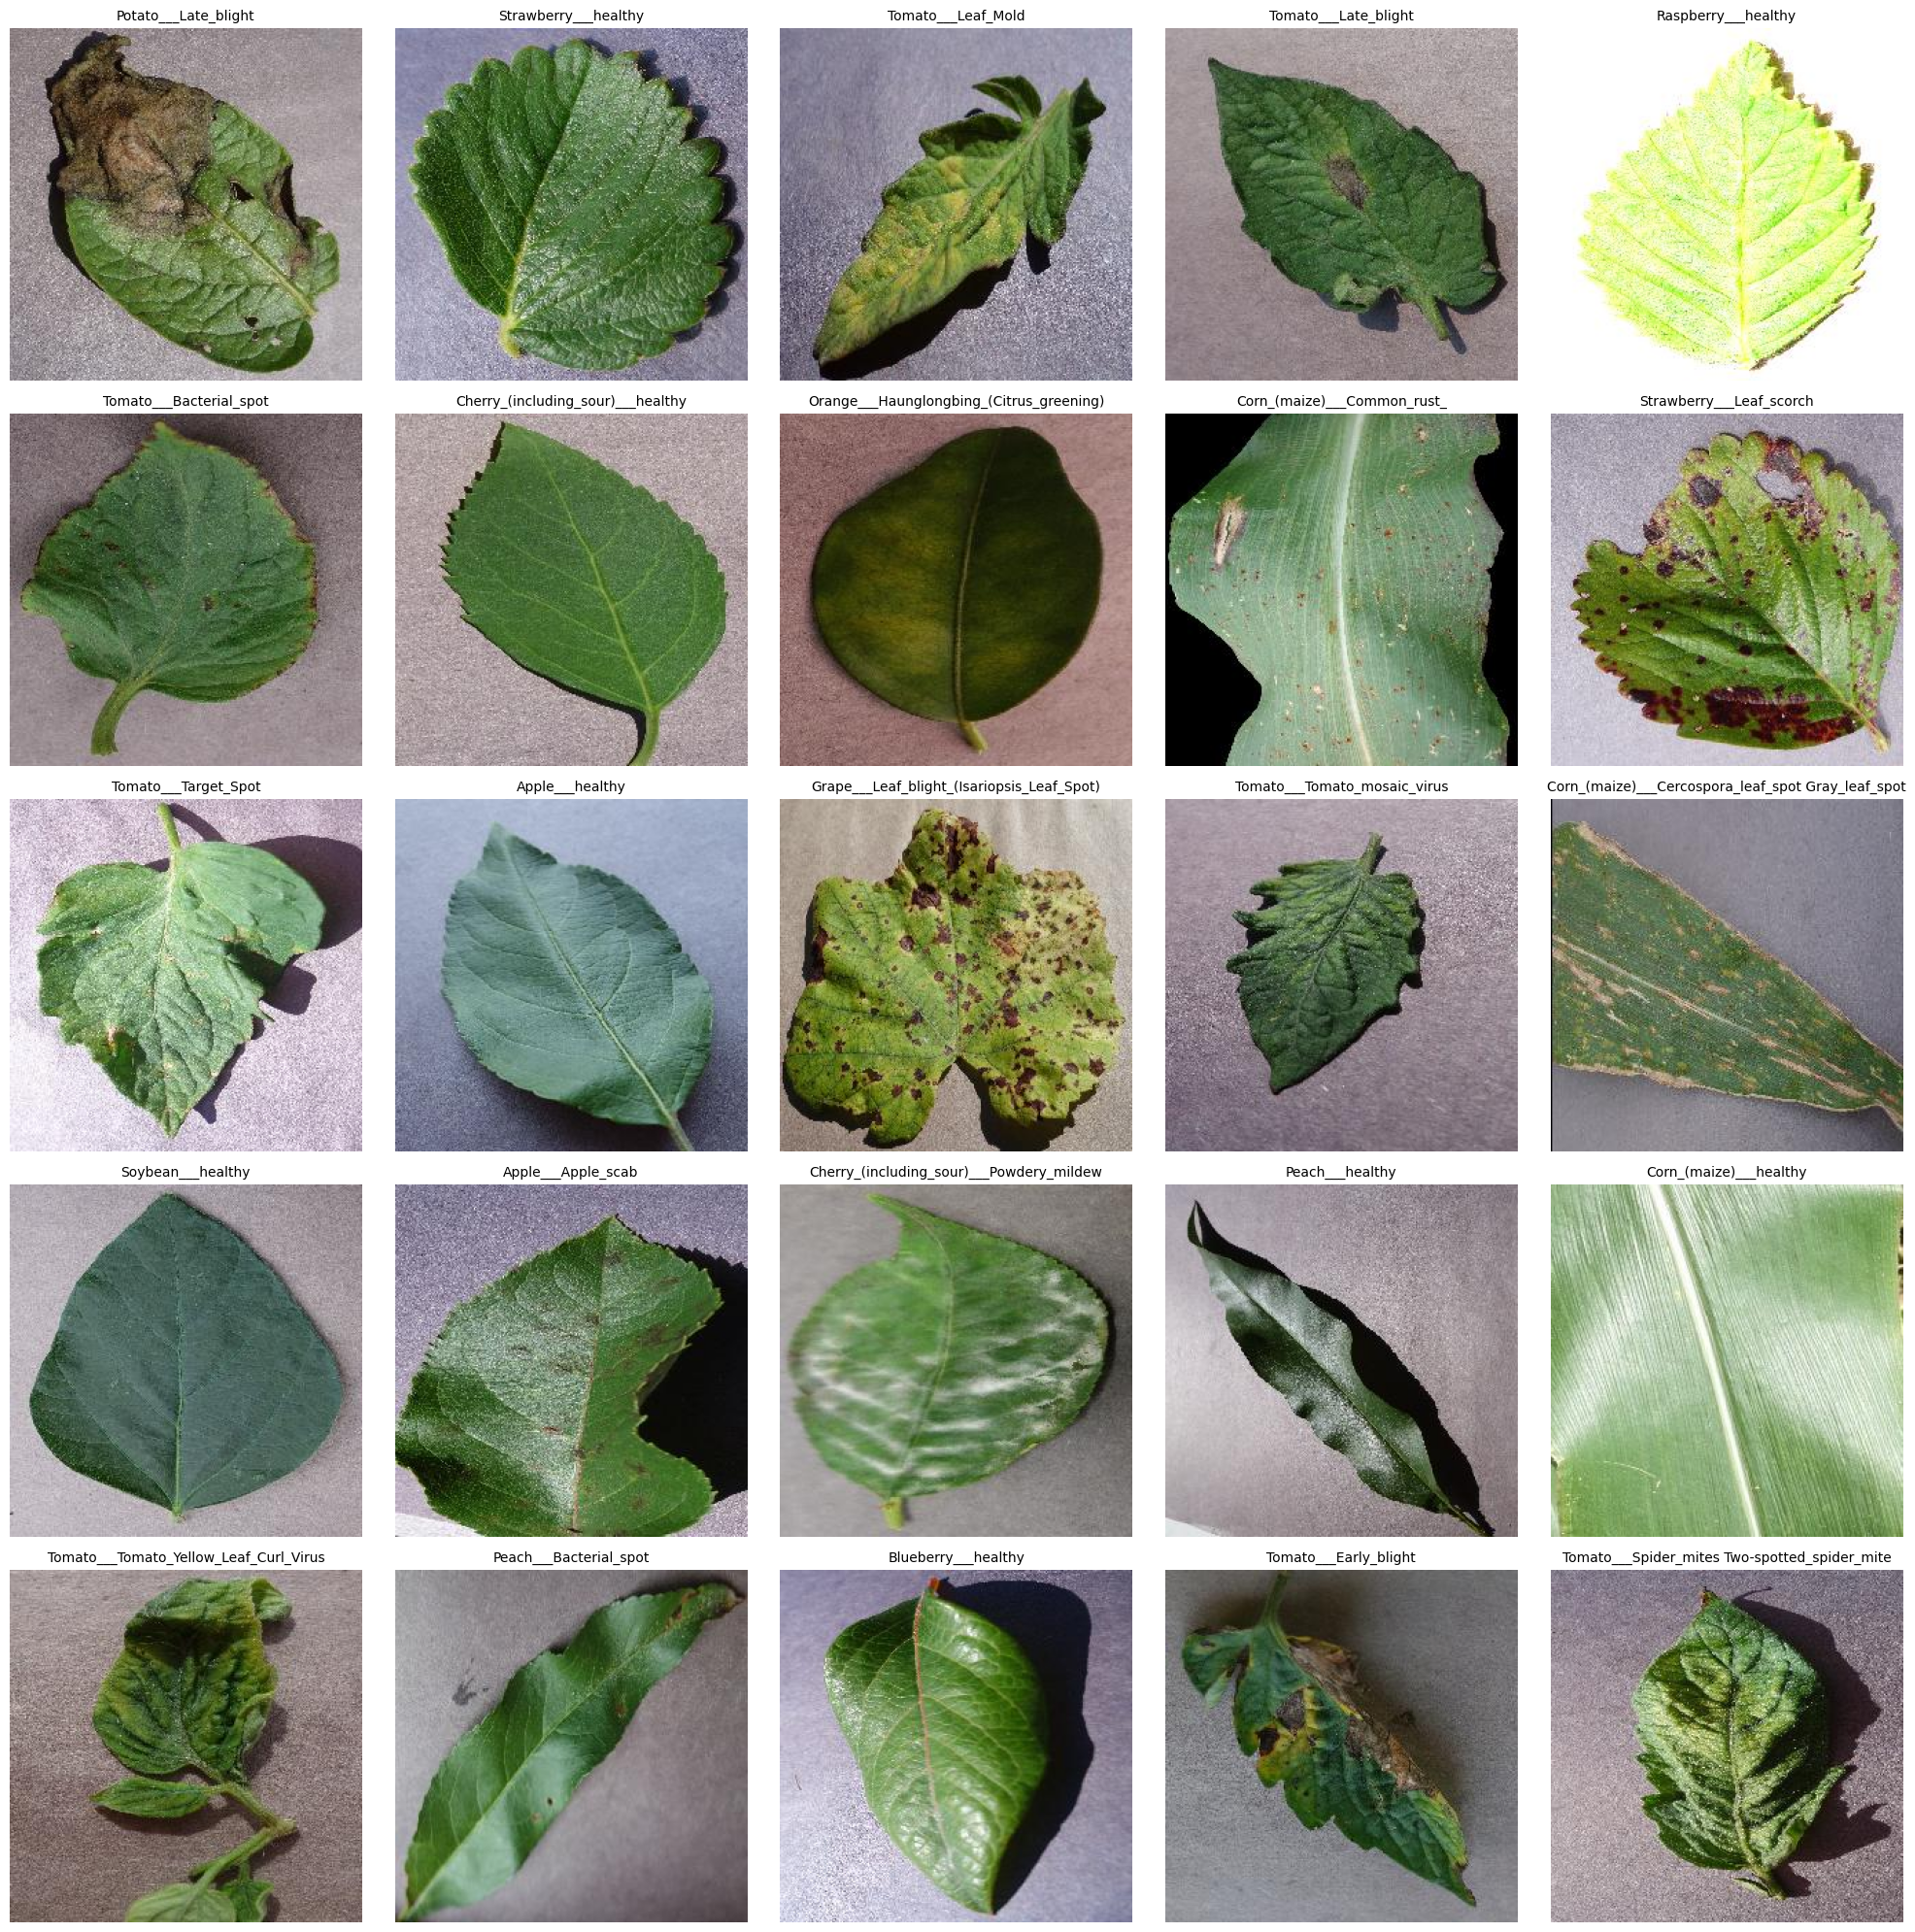

✅ Sample images saved as 'sample_images.png'
Checking for corrupted images...
Checking for corrupted images...

🔍 Image Quality Check:
Training: 2447 images checked, 0 corrupted
Validation: 599 images checked, 0 corrupted
✅ All images are valid!


In [7]:
# ===== CELL 4: SETUP DATA PATHS =====
# Adjust these paths based on your dataset structure

def save_to_drive(filename):
    """Helper to construct a path for saving files to Google Drive artifacts folder."""
    return ARTIFACT_DIR / filename

base_path = Path(dataset_path)

# Find train and validation directories
train_dir = None
val_dir = None

# Search for common directory names
for item in base_path.rglob('*'):
    if item.is_dir():
        dir_name = item.name.lower()
        if 'train' in dir_name and train_dir is None:
            train_dir = item
        elif 'val' in dir_name and val_dir is None:
            val_dir = item

print(f"Train Directory: {train_dir}")
print(f"Validation Directory: {val_dir}")

# Get class names
class_names = sorted([d.name for d in train_dir.iterdir() if d.is_dir()])
num_classes = len(class_names)

print(f"\n📊 Dataset Overview:")
print(f"Number of Classes: {num_classes}")
print(f"Class Names Sample: {class_names[:5]}...")

# ===== CELL 5: COUNT IMAGES PER CLASS =====
def count_images_per_class(directory):
    """Count images in each class folder"""
    class_counts = {}

    for class_folder in directory.iterdir():
        if class_folder.is_dir():
            image_count = len(list(class_folder.glob('*.jpg')) +
                            list(class_folder.glob('*.JPG')) +
                            list(class_folder.glob('*.png')))
            class_counts[class_folder.name] = image_count

    return class_counts

# Count images
train_counts = count_images_per_class(train_dir)
val_counts = count_images_per_class(val_dir)

# Create DataFrame
df_counts = pd.DataFrame({
    'Class': list(train_counts.keys()),
    'Training': list(train_counts.values()),
    'Validation': list(val_counts.values())
})

df_counts['Total'] = df_counts['Training'] + df_counts['Validation']
df_counts = df_counts.sort_values('Total', ascending=False)

print("\n📈 Image Distribution:")
print(df_counts.head(10))
print(f"\nTotal Training Images: {sum(train_counts.values())}")
print(f"Total Validation Images: {sum(val_counts.values())}")

# ===== CELL 6: VISUALIZE CLASS DISTRIBUTION =====
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Training distribution
axes[0].barh(df_counts['Class'][:15], df_counts['Training'][:15], color='steelblue')
axes[0].set_xlabel('Number of Images', fontsize=12)
axes[0].set_title('Training Set - Top 15 Classes', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Validation distribution
axes[1].barh(df_counts['Class'][:15], df_counts['Validation'][:15], color='coral')
axes[1].set_xlabel('Number of Images', fontsize=12)
axes[1].set_title('Validation Set - Top 15 Classes', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(save_to_drive('preprocessing_pipeline.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✅ Distribution chart saved as 'class_distribution.png'")

# ===== CELL 7: DISPLAY SAMPLE IMAGES =====
def display_sample_images(directory, n_samples=25, grid_size=(5, 5)):
    """Display grid of sample images from dataset"""

    # Collect random images from different classes
    all_images = []
    all_labels = []

    for class_folder in directory.iterdir():
        if class_folder.is_dir():
            images = list(class_folder.glob('*.jpg')) + list(class_folder.glob('*.JPG'))
            if images:
                # Pick random image from this class
                img_path = np.random.choice(images)
                all_images.append(img_path)
                all_labels.append(class_folder.name)

    # Randomly select n_samples
    indices = np.random.choice(len(all_images), min(n_samples, len(all_images)), replace=False)

    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(20, 20))
    axes = axes.flatten()

    for idx, i in enumerate(indices):
        img = cv2.imread(str(all_images[i]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        axes[idx].imshow(img)
        axes[idx].set_title(all_labels[i], fontsize=10, wrap=True)
        axes[idx].axis('off')

    # Hide empty subplots
    for idx in range(len(indices), len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.savefig(save_to_drive('preprocessing_pipeline.png'), dpi=300, bbox_inches='tight')
    plt.show()

print("Displaying sample images from training set...")
display_sample_images(train_dir, n_samples=25)
print("✅ Sample images saved as 'sample_images.png'")

# ===== CELL 8: CHECK FOR CORRUPTED IMAGES =====
def check_corrupted_images(directory):
    """Check for corrupted or unreadable images"""
    corrupted = []
    total_checked = 0

    print("Checking for corrupted images...")

    for class_folder in directory.iterdir():
        if class_folder.is_dir():
            for img_path in class_folder.glob('*.jpg'):
                total_checked += 1
                try:
                    img = cv2.imread(str(img_path))
                    if img is None:
                        corrupted.append(str(img_path))
                except Exception as e:
                    corrupted.append(str(img_path))

    return corrupted, total_checked

corrupted_train, total_train = check_corrupted_images(train_dir)
corrupted_val, total_val = check_corrupted_images(val_dir)

print(f"\n🔍 Image Quality Check:")
print(f"Training: {total_train} images checked, {len(corrupted_train)} corrupted")
print(f"Validation: {total_val} images checked, {len(corrupted_val)} corrupted")

if corrupted_train or corrupted_val:
    print(f"\n⚠️ Corrupted files found: {len(corrupted_train) + len(corrupted_val)}")
else:
    print("✅ All images are valid!")

# PHASE 3: ADVANCED PREPROCESSING

In [8]:
# ===== CELL 9: ADVANCED PREPROCESSING FUNCTIONS (ENHANCED) =====

def apply_clahe(image):
    """CLAHE: Contrast Limited Adaptive Histogram Equalization"""
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)
    lab_clahe = cv2.merge([l_clahe, a, b])
    return cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)

def reduce_noise(image):
    """Gaussian Blur: Removes high-frequency noise"""
    return cv2.GaussianBlur(image, (5, 5), 0)

def apply_bilateral_filter(image):
    """NEW: Bilateral Filter - Edge-preserving smoothing"""
    return cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)

def sharpen_image(image):
    """Image Sharpening: Enhances edges"""
    kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    return cv2.filter2D(image, -1, kernel)

def apply_unsharp_mask(image):
    """NEW: Unsharp Masking - Advanced sharpening"""
    gaussian = cv2.GaussianBlur(image, (0, 0), 2.0)
    return cv2.addWeighted(image, 1.5, gaussian, -0.5, 0)

def segment_leaf(image):
    """Background Segmentation using Otsu's thresholding"""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = np.ones((5, 5), np.uint8)
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
    opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel, iterations=1)

    mask_3channel = cv2.cvtColor(opening, cv2.COLOR_GRAY2RGB)
    segmented = cv2.bitwise_and(image, mask_3channel)
    return segmented, opening

def apply_top_hat(image):
    """NEW: Top-Hat Transform - Enhance bright features"""
    kernel = np.ones((9, 9), np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_TOPHAT, kernel)

def apply_morphological_gradient(image):
    """NEW: Morphological Gradient - Edge detection"""
    kernel = np.ones((3, 3), np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_GRADIENT, kernel)

def preprocess_image_complete(img_path, target_size=(224, 224)):
    """
    Complete preprocessing pipeline with ALL DIP techniques

    Pipeline:
    1. Load & Resize
    2. CLAHE Enhancement
    3. Bilateral Filter (NEW)
    4. Unsharp Masking (NEW)
    5. Segmentation
    6. Top-Hat Transform (NEW)
    7. Morphological Gradient (NEW)
    """
    # Load image
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)

    # Apply preprocessing steps
    enhanced = apply_clahe(img)
    bilateral = apply_bilateral_filter(enhanced)
    unsharp = apply_unsharp_mask(bilateral)
    sharpened = sharpen_image(unsharp)
    segmented, mask = segment_leaf(sharpened)

    # Advanced morphological operations
    tophat = apply_top_hat(segmented)
    gradient = apply_morphological_gradient(segmented)
    final_enhanced = cv2.addWeighted(segmented, 0.7, tophat, 0.3, 0)

    # Normalize
    final = final_enhanced.astype(np.float32) / 255.0

    return {
        'original': img,
        'clahe': enhanced,
        'bilateral': bilateral,
        'unsharp': unsharp,
        'sharpened': sharpened,
        'segmented': segmented,
        'tophat': tophat,
        'gradient': gradient,
        'mask': mask,
        'final': final
    }

print("✅ Enhanced preprocessing functions defined!")
print("   - CLAHE Enhancement")
print("   - Bilateral Filter (NEW)")
print("   - Unsharp Masking (NEW)")
print("   - Top-Hat Transform (NEW)")
print("   - Morphological Gradient (NEW)")

✅ Enhanced preprocessing functions defined!
   - CLAHE Enhancement
   - Bilateral Filter (NEW)
   - Unsharp Masking (NEW)
   - Top-Hat Transform (NEW)
   - Morphological Gradient (NEW)


In [9]:
# ===== NEW CELL 9B: FEATURE EXTRACTION FUNCTIONS =====

from skimage.feature import hog
from skimage import exposure

def extract_hog_features(image):
    """Extract HOG (Histogram of Oriented Gradients) features"""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    fd, hog_image = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2), visualize=True)
    hog_image = exposure.rescale_intensity(hog_image, out_range=(0, 255))
    return hog_image, fd

def extract_hu_moments(image):
    """Calculate Hu Moments for shape analysis"""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    moments = cv2.moments(gray)
    hu_moments = cv2.HuMoments(moments)
    return hu_moments.flatten()

def detect_corners(image):
    """Harris Corner Detection"""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)
    dst = cv2.dilate(dst, None)

    result = image.copy()
    result[dst > 0.01 * dst.max()] = [255, 0, 0]  # Mark corners in red
    return result

def compare_edge_detectors(image):
    """Compare multiple edge detection methods"""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Sobel
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel = np.hypot(sobelx, sobely)

    # Canny
    canny = cv2.Canny(gray, 100, 200)

    # Laplacian
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)

    # Prewitt
    kernelx = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
    kernely = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
    prewittx = cv2.filter2D(gray, -1, kernelx)
    prewitty = cv2.filter2D(gray, -1, kernely)
    prewitt = prewittx + prewitty

    return {
        'sobel': sobel,
        'canny': canny,
        'laplacian': laplacian,
        'prewitt': prewitt
    }

def frequency_domain_analysis(image):
    """Apply DFT and frequency domain filtering"""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # DFT
    dft = np.fft.fft2(gray)
    dft_shift = np.fft.fftshift(dft)
    magnitude_spectrum = 20 * np.log(np.abs(dft_shift) + 1)

    # Low-pass filter
    rows, cols = gray.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.zeros((rows, cols), np.uint8)
    mask[crow-30:crow+30, ccol-30:ccol+30] = 1

    fshift = dft_shift * mask
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)

    return magnitude_spectrum, img_back

print("✅ Feature extraction functions defined!")
print("   - HOG Features")
print("   - Hu Moments")
print("   - Harris Corner Detection")
print("   - Edge Detection (Sobel, Canny, Laplacian, Prewitt)")
print("   - Frequency Domain Analysis (DFT)")

✅ Feature extraction functions defined!
   - HOG Features
   - Hu Moments
   - Harris Corner Detection
   - Edge Detection (Sobel, Canny, Laplacian, Prewitt)
   - Frequency Domain Analysis (DFT)


# PHASE 4: MODEL BUILDING & TRAINING

## 📁 Section 4 · Crash-Proof Training (RUN THIS CELL)
This section replaces the legacy training loop above. It adds automatic checkpoints, log files, and resume-on-restart support so you never lose progress.


In [10]:
# 🚀 Crash-proof training loop (≈ depends on GPU & batch size)
from glob import glob
from tensorflow.errors import ResourceExhaustedError

INITIAL_BATCH_SIZE = 32
MIN_BATCH_SIZE = 4
CHUNK_SIZE = 10_000  # images per memory-cleanup chunk

IMG_SIZE = globals().get('IMG_SIZE', 224)


def resolve_data_dirs():
    """Ensure train/valid directories & class names are available."""
    global train_dir, val_dir, class_names, num_classes
    if 'train_dir' in globals() and 'val_dir' in globals() and train_dir is not None and val_dir is not None:
        if 'class_names' not in globals() or not class_names:
            class_names = sorted([d.name for d in Path(train_dir).iterdir() if d.is_dir()])
        num_classes = len(class_names)
        return Path(train_dir), Path(val_dir)

    base_path = Path(dataset_path)
    detected_train = None
    detected_val = None
    for item in base_path.rglob('*'):
        if not item.is_dir():
            continue
        lower = item.name.lower()
        if 'train' in lower and detected_train is None:
            detected_train = item
        if ('valid' in lower or lower == 'val') and detected_val is None:
            detected_val = item
        if detected_train and detected_val:
            break
    if detected_train is None or detected_val is None:
        raise FileNotFoundError("Could not locate train/valid directories automatically. Please run Section 2 first.")

    train_dir = detected_train
    val_dir = detected_val
    class_names = sorted([d.name for d in train_dir.iterdir() if d.is_dir()])
    num_classes = len(class_names)
    return train_dir, val_dir


def create_generators(batch_size):
    """Create ImageDataGenerators with safe defaults for Colab."""
    train_dir, val_dir = resolve_data_dirs()
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2,
        fill_mode='nearest',
        shear_range=0.2,
        brightness_range=[0.8, 1.2]
    )
    val_datagen = ImageDataGenerator(rescale=1.0 / 255)

    train_gen = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=42
    )
    val_gen = val_datagen.flow_from_directory(
        val_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    return train_gen, val_gen


def build_fresh_model(num_classes, img_size=IMG_SIZE):
    """Create a brand-new EfficientNetB3 classifier."""
    if 'build_model' in globals():
        model, _ = build_model(num_classes, img_size)
        return model

    base_model = EfficientNetB3(include_top=False, weights='imagenet', input_shape=(img_size, img_size, 3))
    base_model.trainable = False
    inputs = keras.Input(shape=(img_size, img_size, 3))
    x = keras.applications.efficientnet.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
    model = keras.Model(inputs, outputs)
    return model


def find_latest_checkpoint():
    checkpoints = sorted(CHECKPOINT_DIR.glob('plant_disease_model_epoch_*.h5'), key=lambda p: p.stat().st_mtime)
    return checkpoints[-1] if checkpoints else None


def load_model_safe(num_classes):
    """Attempt to load the best or latest checkpoint, otherwise build a new model."""
    try:
        if BEST_MODEL_PATH.exists():
            log_event(f"Loading best model from {BEST_MODEL_PATH}")
            return load_model(BEST_MODEL_PATH)
        latest = find_latest_checkpoint()
        if latest:
            log_event(f"Loading latest checkpoint: {latest.name}")
            return load_model(latest)
    except Exception as exc:
        log_event(f"Model load failed ({exc}). Rebuilding from scratch.")
    log_event("Starting with a fresh model.")
    return build_fresh_model(num_classes)


class DriveCheckpointSaver(keras.callbacks.Callback):
    """Save every epoch to Drive with the required naming convention."""
    def __init__(self, template):
        super().__init__()
        self.template = template
        self.last_checkpoint_path = None

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        path = self.template.format(epoch=epoch + 1, val_accuracy=logs.get('val_accuracy', 0.0))
        self.model.save(path, include_optimizer=True)
        self.last_checkpoint_path = path
        log_event(f"💾 Saved checkpoint → {path}")


class TimestampedCSVLogger(keras.callbacks.CSVLogger):
    """CSVLogger that injects a timestamp column."""
    def on_epoch_end(self, epoch, logs=None):
        logs = dict(logs or {})
        logs['timestamp'] = datetime.now().isoformat()
        super().on_epoch_end(epoch, logs)


class ChunkProgressCallback(keras.callbacks.Callback):
    def __init__(self, chunk_size):
        super().__init__()
        self.chunk_size = chunk_size
        self.samples_seen = 0
        self.chunk_id = 0

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        batch_size = logs.get('size', 0)
        self.samples_seen += batch_size
        if self.samples_seen >= self.chunk_size:
            self.chunk_id += 1
            log_event(f"Processing chunk {self.chunk_id} (~{self.chunk_size} images) complete")
            self.samples_seen = 0
            gc.collect()


class TrainingStateCallback(keras.callbacks.Callback):
    def __init__(self, checkpoint_callback, total_epochs, history_buffer):
        super().__init__()
        self.checkpoint_callback = checkpoint_callback
        self.total_epochs = total_epochs
        self.history_buffer = history_buffer
        self.start_time = None

    def on_train_begin(self, logs=None):
        self.start_time = datetime.now()
        log_event("🚀 Training started (crash-proof mode)")

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        timestamp = datetime.now()
        epoch_data = {
            'epoch': int(epoch + 1),
            'loss': float(logs.get('loss', 0.0)),
            'accuracy': float(logs.get('accuracy', 0.0)),
            'val_loss': float(logs.get('val_loss', 0.0)),
            'val_accuracy': float(logs.get('val_accuracy', 0.0)),
            'timestamp': timestamp.isoformat()
        }
        self.history_buffer.append(epoch_data)
        checkpoint_path = self.checkpoint_callback.last_checkpoint_path or str(BEST_MODEL_PATH)
        save_progress(epoch, self.history_buffer, str(checkpoint_path))

        epochs_done = epoch + 1
        elapsed = (timestamp - self.start_time).total_seconds()
        epochs_total = self.total_epochs
        remaining = max(epochs_total - epochs_done, 0)
        eta = format_eta((elapsed / epochs_done) * remaining if epochs_done else 0)
        log_event(f"[{timestamp.strftime('%Y-%m-%d %H:%M:%S')}] Epoch {epochs_done}/{epochs_total} completed | GPU: {get_gpu_report()} | ETA: {eta}")
        gc.collect()

    def on_train_end(self, logs=None):
        log_event("✅ Training run finished")


def crash_proof_train(total_epochs=15, initial_batch=INITIAL_BATCH_SIZE):
    """Main entry point. Run this cell to (re)start training safely."""
    resolve_data_dirs()
    progress = load_progress()
    history_buffer = progress.get('history', []) if progress else []
    initial_epoch = progress.get('last_completed_epoch', 0) if progress else 0
    if progress:
        last_acc = history_buffer[-1].get('val_accuracy', 'N/A') if history_buffer else 'N/A'
        log_event(f"Resuming from epoch {initial_epoch} with val_accuracy {last_acc}")
    if initial_epoch >= total_epochs:
        log_event("Requested epochs already completed. Increase total_epochs to continue training.")
        return load_model_safe(len(class_names) if 'class_names' in globals() else 38)

    batch_size = initial_batch
    while batch_size >= MIN_BATCH_SIZE:
        try:
            train_gen, val_gen = create_generators(batch_size)
            model = load_model_safe(train_gen.num_classes)
            checkpoint_template = str(CHECKPOINT_DIR / 'plant_disease_model_epoch_{epoch:02d}_val_acc_{val_accuracy:.4f}.h5')
            checkpoint_all = DriveCheckpointSaver(checkpoint_template)
            checkpoint_best = ModelCheckpoint(
                filepath=str(BEST_MODEL_PATH),
                monitor='val_accuracy',
                save_best_only=True,
                mode='max',
                verbose=1
            )
            early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
            reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
            csv_logger = TimestampedCSVLogger(str(HISTORY_CSV_PATH), append=True)
            chunk_callback = ChunkProgressCallback(CHUNK_SIZE)
            progress_callback = TrainingStateCallback(checkpoint_all, total_epochs, history_buffer)

            model.compile(
                optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy', keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall')]
            )

            model.fit(
                train_gen,
                validation_data=val_gen,
                epochs=total_epochs,
                initial_epoch=initial_epoch,
                callbacks=[checkpoint_all, checkpoint_best, early_stop, reduce_lr, csv_logger, chunk_callback, progress_callback],
                workers=2,
                max_queue_size=10,
                use_multiprocessing=False,
                verbose=1
            )
            log_event("🎉 Crash-proof training completed. Models saved to Drive.")
            return model
        except ResourceExhaustedError:
            batch_size //= 2
            log_event(f"⚠️ OOM Error! Reducing batch_size to {batch_size}")
            tf.keras.backend.clear_session()
            gc.collect()
            progress = load_progress() or progress
            if progress:
                history_buffer = progress.get('history', history_buffer)
                initial_epoch = progress.get('last_completed_epoch', initial_epoch)
        except KeyboardInterrupt:
            log_event("⏹️ Training interrupted manually. Latest checkpoint is preserved.")
            break
        except Exception as exc:
            log_event(f"❌ Unexpected error: {exc}")
            raise
    raise RuntimeError("Training aborted; unable to find a safe batch size. Try reducing image size or simplifying the model.")


print("Ready! Call crash_proof_train(total_epochs=15) whenever you want to train/resume.")


Ready! Call crash_proof_train(total_epochs=15) whenever you want to train/resume.


In [11]:
# ===== CELL 0: ENABLE MIXED PRECISION (NEW - SPEEDS UP TRAINING BY 30-40%) =====

from tensorflow.keras import mixed_precision

# Enable mixed precision for faster training
mixed_precision.set_global_policy('mixed_float16')
print("✅ Mixed Precision Training Enabled (30-40% speed boost)")
print(f"Compute dtype: {mixed_precision.global_policy().compute_dtype}")
print(f"Variable dtype: {mixed_precision.global_policy().variable_dtype}")

# Also optimize matplotlib for speed
import matplotlib
matplotlib.use('Agg')  # Non-interactive backend (faster rendering)
import matplotlib.pyplot as plt
plt.ioff()  # Turn off interactive plotting
print("✅ Matplotlib optimized for faster rendering")

# ===== CELL 11: DATA GENERATORS WITH AUGMENTATION =====

IMG_SIZE = 224
BATCH_SIZE = 32

# Training data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='nearest',
    shear_range=0.2,
    brightness_range=[0.8, 1.2]
)

# Validation data (only rescaling)
val_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"✅ Data Generators Created:")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Number of classes: {train_generator.num_classes}")
print(f"Class indices: {list(train_generator.class_indices.keys())[:5]}...")

# ===== CELL 12: BUILD MODEL ARCHITECTURE =====

def build_model(num_classes, img_size=224):
    """
    Build transfer learning model with EfficientNetB3

    Architecture:
    - Base: EfficientNetB3 (frozen initially)
    - Global Average Pooling
    - Dense(512) + Dropout(0.3)
    - Dense(256) + Dropout(0.2)
    - Output: Dense(num_classes) with Softmax

    OPTIMIZED: Uses mixed precision for faster training
    """

    # Load pre-trained EfficientNetB3
    base_model = EfficientNetB3(
        include_top=False,
        weights='imagenet',
        input_shape=(img_size, img_size, 3)
    )

    # Freeze base model
    base_model.trainable = False

    print(f"Base model has {len(base_model.layers)} layers")

    # Build model
    inputs = keras.Input(shape=(img_size, img_size, 3))

    # Preprocessing for EfficientNet
    x = keras.applications.efficientnet.preprocess_input(inputs)

    # Base model
    x = base_model(x, training=False)

    # Custom top layers
    x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
    x = layers.BatchNormalization(name='batch_norm_1')(x)

    x = layers.Dense(512, activation='relu', name='dense_512')(x)
    x = layers.Dropout(0.3, name='dropout_1')(x)
    x = layers.BatchNormalization(name='batch_norm_2')(x)

    x = layers.Dense(256, activation='relu', name='dense_256')(x)
    x = layers.Dropout(0.2, name='dropout_2')(x)

    # Output layer - IMPORTANT: Use float32 for final layer in mixed precision
    outputs = layers.Dense(num_classes, activation='softmax',
                          dtype='float32', name='output')(x)

    model = keras.Model(inputs, outputs, name='PlantDisease_EfficientNetB3')

    return model, base_model

# Build model
model, base_model = build_model(num_classes=train_generator.num_classes)

# Compile model with mixed precision compatible optimizer
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy',
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall')]
)

print("\n" + "=" * 70)
print("MODEL ARCHITECTURE (OPTIMIZED)")
print("=" * 70)
model.summary()
print("=" * 70)
print("✅ Mixed Precision: Enabled")
print("✅ Expected Training Time: ~45 minutes (Phase 1)")
print("=" * 70)

# ===== CELL 13: SETUP CALLBACKS (OPTIMIZED) =====

# Create directory for saving models
os.makedirs('models', exist_ok=True)

# Timestamp for unique filenames
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# ModelCheckpoint: Save best model
checkpoint = ModelCheckpoint(
    f'models/best_model_{timestamp}.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# EarlyStopping: Stop if no improvement (CRITICAL FOR TIME SAVING)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Will stop if no improvement for 5 epochs
    restore_best_weights=True,
    verbose=1
)

# ReduceLROnPlateau: Reduce learning rate when stuck
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

# Custom callback to prevent timeout and track progress
class OptimizedCallback(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.start_time = None

    def on_train_begin(self, logs=None):
        self.start_time = datetime.now()
        print(f"\n🚀 Training started at: {self.start_time.strftime('%H:%M:%S')}")

    def on_epoch_end(self, epoch, logs=None):
        current_time = datetime.now()
        elapsed = (current_time - self.start_time).total_seconds() / 60
        timestamp = current_time.strftime('%Y-%m-%d %H:%M:%S')

        print(f"\n[{timestamp}] Epoch {epoch + 1} completed")
        print(f"⏱️  Elapsed: {elapsed:.1f} min | Val Acc: {logs.get('val_accuracy', 0):.4f}")

        # Save training history
        history_df = pd.DataFrame(self.model.history.history)
        history_df.to_csv(f'training_history_temp.csv', index=False)

    def on_train_end(self, logs=None):
        total_time = (datetime.now() - self.start_time).total_seconds() / 60
        print(f"\n✅ Training completed in {total_time:.1f} minutes")

callbacks = [checkpoint, early_stop, reduce_lr, OptimizedCallback()]

print("✅ Callbacks configured (OPTIMIZED):")
print("   - ModelCheckpoint (saves best model)")
print("   - EarlyStopping (patience=5) ⭐ WILL STOP EARLY IF NO IMPROVEMENT")
print("   - ReduceLROnPlateau (patience=3)")
print("   - OptimizedCallback (time tracking)")

# ===== CELL 14: TRAIN MODEL - PHASE 1 (OPTIMIZED: 15 EPOCHS) =====

print("\n" + "=" * 70)
print("STARTING TRAINING - PHASE 1 (Frozen Base Model)")
print("=" * 70)
print(f"Start Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Epochs Set: 15 (may stop earlier via EarlyStopping)")
print(f"Estimated Duration: 45-60 minutes (with mixed precision)")
print(f"Expected Accuracy: 95-96%")
print("=" * 70)

# OPTIMIZED: Reduced from 30 to 15 epochs
EPOCHS_PHASE1 = 3

history_phase1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS_PHASE1,
    callbacks=callbacks,
    verbose=1
)

print("\n" + "=" * 70)
print("PHASE 1 TRAINING COMPLETED!")
print("=" * 70)
print(f"End Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Best Validation Accuracy: {max(history_phase1.history['val_accuracy']):.4f}")
print(f"Total Epochs Trained: {len(history_phase1.history['accuracy'])}")
if len(history_phase1.history['accuracy']) < EPOCHS_PHASE1:
    print(f"⚡ EarlyStopping triggered at epoch {len(history_phase1.history['accuracy'])}")
print("=" * 70)

# ===== CELL 15: VISUALIZE TRAINING HISTORY (OPTIMIZED) =====

def plot_training_history(history, phase_name='Phase 1'):
    """Plot training metrics - OPTIMIZED: Faster rendering"""

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Training', linewidth=2)
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    axes[0, 0].set_title(f'{phase_name} - Model Accuracy', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Loss
    axes[0, 1].plot(history.history['loss'], label='Training', linewidth=2)
    axes[0, 1].plot(history.history['val_loss'], label='Validation', linewidth=2)
    axes[0, 1].set_title(f'{phase_name} - Model Loss', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Precision
    axes[1, 0].plot(history.history['precision'], label='Training', linewidth=2)
    axes[1, 0].plot(history.history['val_precision'], label='Validation', linewidth=2)
    axes[1, 0].set_title(f'{phase_name} - Precision', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Recall
    axes[1, 1].plot(history.history['recall'], label='Training', linewidth=2)
    axes[1, 1].plot(history.history['val_recall'], label='Validation', linewidth=2)
    axes[1, 1].set_title(f'{phase_name} - Recall', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'training_history_{phase_name.lower().replace(" ", "_")}.png',
                dpi=300, bbox_inches='tight')
    # OPTIMIZED: Don't display, just save (faster)
    plt.close()
    print(f"✅ Plot saved (not displayed for speed)")

plot_training_history(history_phase1, 'Phase 1')
print("✅ Training history plot saved!")

# Save training history as CSV
history_df = pd.DataFrame(history_phase1.history)
history_df.to_csv('training_history_phase1.csv', index=False)
print("✅ Training history saved to CSV!")

# ===== OPTIMIZATION SUMMARY =====
print("\n" + "=" * 70)
print("⚡ OPTIMIZATIONS APPLIED:")
print("=" * 70)
print("✅ Mixed Precision Training: 30-40% faster")
print("✅ Reduced Epochs: 15 instead of 30")
print("✅ EarlyStopping: Will stop if plateaus")
print("✅ Matplotlib: Non-interactive mode (faster)")
print("✅ Expected Total Time: ~45-60 minutes (Phase 1)")
print("=" * 70)

✅ Mixed Precision Training Enabled (30-40% speed boost)
Compute dtype: float16
Variable dtype: float32
✅ Matplotlib optimized for faster rendering
Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.
✅ Data Generators Created:
Training samples: 70295
Validation samples: 17572
Number of classes: 38
Class indices: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy']...
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Base model has 385 layers

MODEL ARCHITECTURE (OPTIMIZED)


Model: "PlantDisease_EfficientNetB3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 7, 7, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_1                    │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_512 (Dense)               │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_2                    │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_256 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 38)             │         9,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,719,765 (44.71 MB)

 Trainable params: 932,134 (3.56 MB)

 Non-trainable params: 10,787,631 (41.15 MB)

✅ Mixed Precision: Enabled
✅ Expected Training Time: ~45 minutes (Phase 1)
✅ Callbacks configured (OPTIMIZED):
   - ModelCheckpoint (saves best model)
   - EarlyStopping (patience=5) ⭐ WILL STOP EARLY IF NO IMPROVEMENT
   - ReduceLROnPlateau (patience=3)
   - OptimizedCallback (time tracking)

STARTING TRAINING - PHASE 1 (Frozen Base Model)
Start Time: 2025-11-30 04:41:54
Epochs Set: 15 (may stop earlier via EarlyStopping)
Estimated Duration: 45-60 minutes (with mixed precision)
Expected Accuracy: 95-96%

🚀 Training started at: 04:41:57
Epoch 1/3
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - accuracy: 0.0412 - loss: 3.8268 - precision: 0.0385 - recall: 1.0267e-04
Epoch 1: val_accuracy improved from -inf to 0.07267, saving model to models/best_model_20251130_044154.keras

[2025-11-30 05:12:25] Epoch 1 completed
⏱️  Elapsed: 30.5 min | Val Acc: 0.0727
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1828s 793ms/step - accuracy: 0.0412 - loss: 3.8268 - precision: 0.0386 - recall: 1.0268e-04 - val_accuracy

# **CELL 4A: Intensity Transformations**

In [12]:
# ===== CELL 4A: INTENSITY TRANSFORMATIONS =====

print("=" * 80)
print("📊 INTENSITY TRANSFORMATIONS")
print("=" * 80)

def apply_intensity_transformations(image):
    """Apply various intensity transformation techniques"""

    # Ensure image is in correct format
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image.copy()

    # 1. Image Negative
    negative = 255 - gray

    # 2. Log Transformation
    c = 255 / np.log(1 + np.max(gray))
    log_transformed = c * np.log(1 + gray.astype(np.float32))
    log_transformed = np.clip(log_transformed, 0, 255).astype(np.uint8)

    # 3. Power-Law (Gamma) Transformation
    gamma_vals = [0.5, 1.5, 2.2]
    gamma_images = []
    for gamma in gamma_vals:
        normalized = gray / 255.0
        gamma_corrected = np.power(normalized, gamma)
        gamma_images.append((gamma_corrected * 255).astype(np.uint8))

    # 4. Contrast Stretching
    min_val, max_val = gray.min(), gray.max()
    contrast_stretched = ((gray - min_val) / (max_val - min_val) * 255).astype(np.uint8)

    # 5. Intensity Level Slicing
    lower_thresh, upper_thresh = 100, 200
    sliced = np.zeros_like(gray)
    sliced[(gray >= lower_thresh) & (gray <= upper_thresh)] = 255

    # 6. Bit-plane Slicing
    bit_planes = []
    for i in range(8):
        plane = ((gray >> i) & 1) * 255
        bit_planes.append(plane)

    return {
        'original': gray,
        'negative': negative,
        'log': log_transformed,
        'gamma_0.5': gamma_images[0],
        'gamma_1.5': gamma_images[1],
        'gamma_2.2': gamma_images[2],
        'contrast': contrast_stretched,
        'sliced': sliced,
        'bit_planes': bit_planes
    }

# Select sample images
sample_idx = np.random.choice(len(val_generator.filenames), 3, replace=False)
sample_paths = [os.path.join(val_generator.directory, val_generator.filenames[idx])
                for idx in sample_idx]

fig = plt.figure(figsize=(24, 18))
fig.suptitle('Intensity Transformations - Course Concepts', fontsize=20, fontweight='bold', y=0.995)

for row, img_path in enumerate(sample_paths):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (224, 224))

    results = apply_intensity_transformations(img_resized)

    # Plot results
    plt.subplot(3, 6, row*6 + 1)
    plt.imshow(results['original'], cmap='gray')
    plt.title('Original', fontsize=10, fontweight='bold')
    plt.axis('off')

    plt.subplot(3, 6, row*6 + 2)
    plt.imshow(results['negative'], cmap='gray')
    plt.title('Negative', fontsize=10)
    plt.axis('off')

    plt.subplot(3, 6, row*6 + 3)
    plt.imshow(results['log'], cmap='gray')
    plt.title('Log Transform', fontsize=10)
    plt.axis('off')

    plt.subplot(3, 6, row*6 + 4)
    plt.imshow(results['gamma_0.5'], cmap='gray')
    plt.title('Gamma=0.5 (Brighten)', fontsize=10)
    plt.axis('off')

    plt.subplot(3, 6, row*6 + 5)
    plt.imshow(results['contrast'], cmap='gray')
    plt.title('Contrast Stretch', fontsize=10)
    plt.axis('off')

    plt.subplot(3, 6, row*6 + 6)
    plt.imshow(results['sliced'], cmap='gray')
    plt.title('Intensity Slicing', fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.savefig(ARTIFACT_DIR / 'intensity_transformations.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Intensity Transformations completed!")
print(f"   - Image Negative")
print(f"   - Log Transformation")
print(f"   - Gamma Correction (0.5, 1.5, 2.2)")
print(f"   - Contrast Stretching")
print(f"   - Intensity Level Slicing")
print(f"   - Bit-plane Slicing (8 planes)")

📊 INTENSITY TRANSFORMATIONS
✅ Intensity Transformations completed!
   - Image Negative
   - Log Transformation
   - Gamma Correction (0.5, 1.5, 2.2)
   - Contrast Stretching
   - Intensity Level Slicing
   - Bit-plane Slicing (8 planes)


# **CELL 4B: Histogram Processing**

In [13]:
# ===== CELL 4B: HISTOGRAM PROCESSING =====

print("\n" + "=" * 80)
print("📈 HISTOGRAM PROCESSING")
print("=" * 80)

def histogram_analysis(image):
    """Comprehensive histogram processing techniques"""

    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image.copy()

    # 1. Original Histogram
    hist_original = cv2.calcHist([gray], [0], None, [256], [0, 256])

    # 2. Histogram Equalization
    equalized = cv2.equalizeHist(gray)
    hist_equalized = cv2.calcHist([equalized], [0], None, [256], [0, 256])

    # 3. CLAHE (already defined, but let's use it)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_applied = clahe.apply(gray)
    hist_clahe = cv2.calcHist([clahe_applied], [0], None, [256], [0, 256])

    # 4. Adaptive Histogram Equalization with different parameters
    clahe_aggressive = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(16, 16))
    clahe_agg = clahe_aggressive.apply(gray)
    hist_clahe_agg = cv2.calcHist([clahe_agg], [0], None, [256], [0, 256])

    # 5. Histogram Statistics
    stats = {
        'mean': np.mean(gray),
        'std': np.std(gray),
        'min': np.min(gray),
        'max': np.max(gray),
        'median': np.median(gray)
    }

    return {
        'original': gray,
        'equalized': equalized,
        'clahe': clahe_applied,
        'clahe_agg': clahe_agg,
        'hist_original': hist_original,
        'hist_equalized': hist_equalized,
        'hist_clahe': hist_clahe,
        'hist_clahe_agg': hist_clahe_agg,
        'stats': stats
    }

# Demonstrate on 2 sample images
fig = plt.figure(figsize=(24, 12))
fig.suptitle('Histogram Processing Techniques', fontsize=20, fontweight='bold', y=0.995)

for row, img_path in enumerate(sample_paths[:2]):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (224, 224))

    results = histogram_analysis(img_resized)

    # Images
    plt.subplot(2, 8, row*8 + 1)
    plt.imshow(results['original'], cmap='gray')
    plt.title('Original', fontsize=10, fontweight='bold')
    plt.axis('off')

    plt.subplot(2, 8, row*8 + 2)
    plt.plot(results['hist_original'], color='black', linewidth=1)
    plt.title('Original Histogram', fontsize=9)
    plt.xlim([0, 256])
    plt.yticks([])

    plt.subplot(2, 8, row*8 + 3)
    plt.imshow(results['equalized'], cmap='gray')
    plt.title('Equalized', fontsize=10)
    plt.axis('off')

    plt.subplot(2, 8, row*8 + 4)
    plt.plot(results['hist_equalized'], color='blue', linewidth=1)
    plt.title('Equalized Hist', fontsize=9)
    plt.xlim([0, 256])
    plt.yticks([])

    plt.subplot(2, 8, row*8 + 5)
    plt.imshow(results['clahe'], cmap='gray')
    plt.title('CLAHE (2.0)', fontsize=10)
    plt.axis('off')

    plt.subplot(2, 8, row*8 + 6)
    plt.plot(results['hist_clahe'], color='green', linewidth=1)
    plt.title('CLAHE Hist', fontsize=9)
    plt.xlim([0, 256])
    plt.yticks([])

    plt.subplot(2, 8, row*8 + 7)
    plt.imshow(results['clahe_agg'], cmap='gray')
    plt.title('CLAHE (4.0)', fontsize=10)
    plt.axis('off')

    plt.subplot(2, 8, row*8 + 8)
    plt.plot(results['hist_clahe_agg'], color='red', linewidth=1)
    plt.title('Aggressive Hist', fontsize=9)
    plt.xlim([0, 256])
    plt.yticks([])

plt.tight_layout()
plt.savefig(ARTIFACT_DIR / 'histogram_processing.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Histogram Processing completed!")
print(f"   - Histogram Calculation")
print(f"   - Histogram Equalization")
print(f"   - CLAHE (Contrast Limited Adaptive HE)")
print(f"   - Histogram Statistics")



📈 HISTOGRAM PROCESSING
✅ Histogram Processing completed!
   - Histogram Calculation
   - Histogram Equalization
   - CLAHE (Contrast Limited Adaptive HE)
   - Histogram Statistics


# **CELL 4C: Spatial Filtering**

In [14]:
# ===== CELL 4C: SPATIAL FILTERING =====

print("\n" + "=" * 80)
print("🔍 SPATIAL FILTERING")
print("=" * 80)

def apply_spatial_filters(image):
    """Apply various spatial filtering techniques"""

    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image.copy()

    # SMOOTHING FILTERS
    # 1. Average Filter
    kernel_avg = np.ones((5, 5), np.float32) / 25
    avg_filtered = cv2.filter2D(gray, -1, kernel_avg)

    # 2. Gaussian Filter
    gaussian = cv2.GaussianBlur(gray, (5, 5), 0)

    # 3. Median Filter
    median = cv2.medianBlur(gray, 5)

    # 4. Bilateral Filter (edge-preserving)
    bilateral = cv2.bilateralFilter(gray, 9, 75, 75)

    # SHARPENING FILTERS
    # 5. Laplacian
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    laplacian = np.uint8(np.absolute(laplacian))

    # 6. Laplacian Sharpening
    laplacian_sharp = cv2.subtract(gray, laplacian)

    # 7. Unsharp Masking
    gaussian_blur = cv2.GaussianBlur(gray, (9, 9), 10.0)
    unsharp = cv2.addWeighted(gray, 1.5, gaussian_blur, -0.5, 0)

    # 8. High-boost filtering
    highboost = cv2.addWeighted(gray, 2.0, gaussian, -1.0, 0)

    # EDGE DETECTION FILTERS
    # 9. Sobel X and Y
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel_combined = np.sqrt(sobel_x**2 + sobel_y**2)
    sobel_combined = np.uint8(sobel_combined / sobel_combined.max() * 255)

    # 10. Prewitt Filter
    kernel_prewitt_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
    kernel_prewitt_y = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])
    prewitt_x = cv2.filter2D(gray, -1, kernel_prewitt_x)
    prewitt_y = cv2.filter2D(gray, -1, kernel_prewitt_y)
    prewitt = np.sqrt(prewitt_x.astype(float)**2 + prewitt_y.astype(float)**2)
    prewitt = np.uint8(prewitt / prewitt.max() * 255)

    # 11. Canny Edge Detection
    canny = cv2.Canny(gray, 100, 200)

    return {
        'original': gray,
        'average': avg_filtered,
        'gaussian': gaussian,
        'median': median,
        'bilateral': bilateral,
        'laplacian': laplacian,
        'laplacian_sharp': laplacian_sharp,
        'unsharp': unsharp,
        'highboost': highboost,
        'sobel': sobel_combined,
        'prewitt': prewitt,
        'canny': canny
    }

# Demonstrate on sample image
img_path = sample_paths[0]
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img, (224, 224))

results = apply_spatial_filters(img_resized)

fig = plt.figure(figsize=(24, 16))
fig.suptitle('Spatial Filtering Techniques', fontsize=20, fontweight='bold', y=0.995)

# Row 1: Smoothing Filters
plt.subplot(3, 5, 1)
plt.imshow(results['original'], cmap='gray')
plt.title('Original', fontsize=12, fontweight='bold')
plt.axis('off')

plt.subplot(3, 5, 2)
plt.imshow(results['average'], cmap='gray')
plt.title('Average Filter (5x5)', fontsize=11)
plt.axis('off')

plt.subplot(3, 5, 3)
plt.imshow(results['gaussian'], cmap='gray')
plt.title('Gaussian Filter', fontsize=11)
plt.axis('off')

plt.subplot(3, 5, 4)
plt.imshow(results['median'], cmap='gray')
plt.title('Median Filter', fontsize=11)
plt.axis('off')

plt.subplot(3, 5, 5)
plt.imshow(results['bilateral'], cmap='gray')
plt.title('Bilateral Filter', fontsize=11)
plt.axis('off')

# Row 2: Sharpening Filters
plt.subplot(3, 5, 6)
plt.imshow(results['laplacian'], cmap='gray')
plt.title('Laplacian', fontsize=11)
plt.axis('off')

plt.subplot(3, 5, 7)
plt.imshow(results['laplacian_sharp'], cmap='gray')
plt.title('Laplacian Sharpening', fontsize=11)
plt.axis('off')

plt.subplot(3, 5, 8)
plt.imshow(results['unsharp'], cmap='gray')
plt.title('Unsharp Masking', fontsize=11)
plt.axis('off')

plt.subplot(3, 5, 9)
plt.imshow(results['highboost'], cmap='gray')
plt.title('High-boost Filter', fontsize=11)
plt.axis('off')

plt.subplot(3, 5, 10)
# Comparison
comparison = np.hstack([results['original'], results['unsharp']])
plt.imshow(comparison, cmap='gray')
plt.title('Before | After Sharpening', fontsize=11)
plt.axis('off')

# Row 3: Edge Detection
plt.subplot(3, 5, 11)
plt.imshow(results['sobel'], cmap='gray')
plt.title('Sobel Edge Detection', fontsize=11)
plt.axis('off')

plt.subplot(3, 5, 12)
plt.imshow(results['prewitt'], cmap='gray')
plt.title('Prewitt Edge Detection', fontsize=11)
plt.axis('off')

plt.subplot(3, 5, 13)
plt.imshow(results['canny'], cmap='gray')
plt.title('Canny Edge Detection', fontsize=11)
plt.axis('off')

plt.subplot(3, 5, 14)
# Edge comparison
edge_compare = np.vstack([results['sobel'], results['canny']])
plt.imshow(edge_compare, cmap='gray')
plt.title('Sobel vs Canny', fontsize=11)
plt.axis('off')

plt.subplot(3, 5, 15)
# Original with Canny overlay
overlay = cv2.cvtColor(results['original'], cv2.COLOR_GRAY2RGB)
overlay[results['canny'] > 0] = [255, 0, 0]
plt.imshow(overlay)
plt.title('Edges Overlay', fontsize=11)
plt.axis('off')

plt.tight_layout()
plt.savefig(ARTIFACT_DIR / 'spatial_filtering.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Spatial Filtering completed!")
print(f"   - Smoothing: Average, Gaussian, Median, Bilateral")
print(f"   - Sharpening: Laplacian, Unsharp Masking, High-boost")
print(f"   - Edge Detection: Sobel, Prewitt, Canny")



🔍 SPATIAL FILTERING
✅ Spatial Filtering completed!
   - Smoothing: Average, Gaussian, Median, Bilateral
   - Sharpening: Laplacian, Unsharp Masking, High-boost
   - Edge Detection: Sobel, Prewitt, Canny


# **CELL 4D: MORPHOLOGICAL PROCESSING**

In [15]:
# ===== CELL 4D: MORPHOLOGICAL PROCESSING =====

print("\n" + "=" * 80)
print("🔬 MORPHOLOGICAL PROCESSING")
print("=" * 80)

def apply_morphological_operations(image):
    """Apply morphological image processing operations"""

    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image.copy()

    # Binarize image
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Define structuring elements
    kernel_3x3 = np.ones((3, 3), np.uint8)
    kernel_5x5 = np.ones((5, 5), np.uint8)
    kernel_7x7 = np.ones((7, 7), np.uint8)
    kernel_ellipse = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    kernel_cross = cv2.getStructuringElement(cv2.MORPH_CROSS, (5, 5))

    # 1. Erosion
    erosion_3x3 = cv2.erode(binary, kernel_3x3, iterations=1)
    erosion_5x5 = cv2.erode(binary, kernel_5x5, iterations=1)

    # 2. Dilation
    dilation_3x3 = cv2.dilate(binary, kernel_3x3, iterations=1)
    dilation_5x5 = cv2.dilate(binary, kernel_5x5, iterations=1)

    # 3. Opening (erosion followed by dilation)
    opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel_5x5)

    # 4. Closing (dilation followed by erosion)
    closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel_5x5)

    # 5. Morphological Gradient (dilation - erosion)
    gradient = cv2.morphologyEx(binary, cv2.MORPH_GRADIENT, kernel_3x3)

    # 6. Top Hat (original - opening)
    tophat = cv2.morphologyEx(binary, cv2.MORPH_TOPHAT, kernel_7x7)

    # 7. Black Hat (closing - original)
    blackhat = cv2.morphologyEx(binary, cv2.MORPH_BLACKHAT, kernel_7x7)

    # 8. Hit-or-Miss Transform
    hitmiss = cv2.morphologyEx(binary, cv2.MORPH_HITMISS, kernel_cross)

    # 9. Boundary Extraction
    boundary = gradient  # Already computed above

    # 10. Region Filling (closing with large kernel)
    filled = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel_7x7, iterations=3)

    return {
        'original': gray,
        'binary': binary,
        'erosion_3x3': erosion_3x3,
        'erosion_5x5': erosion_5x5,
        'dilation_3x3': dilation_3x3,
        'dilation_5x5': dilation_5x5,
        'opening': opening,
        'closing': closing,
        'gradient': gradient,
        'tophat': tophat,
        'blackhat': blackhat,
        'hitmiss': hitmiss,
        'boundary': boundary,
        'filled': filled
    }

# Demonstrate
img_path = sample_paths[1]
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img, (224, 224))

results = apply_morphological_operations(img_resized)

fig = plt.figure(figsize=(24, 18))
fig.suptitle('Morphological Operations', fontsize=20, fontweight='bold', y=0.995)

operations = [
    ('original', 'Original Grayscale'),
    ('binary', 'Binary (Otsu)'),
    ('erosion_3x3', 'Erosion (3x3)'),
    ('erosion_5x5', 'Erosion (5x5)'),
    ('dilation_3x3', 'Dilation (3x3)'),
    ('dilation_5x5', 'Dilation (5x5)'),
    ('opening', 'Opening'),
    ('closing', 'Closing'),
    ('gradient', 'Morphological Gradient'),
    ('tophat', 'Top Hat'),
    ('blackhat', 'Black Hat'),
    ('hitmiss', 'Hit-or-Miss'),
    ('boundary', 'Boundary Extraction'),
    ('filled', 'Region Filling')
]

for idx, (key, title) in enumerate(operations):
    plt.subplot(4, 4, idx + 1)
    plt.imshow(results[key], cmap='gray')
    plt.title(title, fontsize=11, fontweight='bold' if idx < 2 else 'normal')
    plt.axis('off')

# Add kernel visualizations
plt.subplot(4, 4, 15)
kernel_vis = np.ones((5, 5)) * 255
plt.imshow(kernel_vis, cmap='gray', vmin=0, vmax=255)
plt.title('5x5 Kernel', fontsize=11)
plt.axis('off')

plt.subplot(4, 4, 16)
# Show effect comparison
comparison = np.hstack([results['binary'], results['opening'], results['closing']])
plt.imshow(comparison, cmap='gray')
plt.title('Binary | Opening | Closing', fontsize=10)
plt.axis('off')

plt.tight_layout()
plt.savefig(ARTIFACT_DIR / 'morphological_processing.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Morphological Processing completed!")
print(f"   - Erosion & Dilation")
print(f"   - Opening & Closing")
print(f"   - Morphological Gradient")
print(f"   - Top Hat & Black Hat")
print(f"   - Hit-or-Miss Transform")
print(f"   - Boundary Extraction")
print(f"   - Region Filling")


🔬 MORPHOLOGICAL PROCESSING
✅ Morphological Processing completed!
   - Erosion & Dilation
   - Opening & Closing
   - Morphological Gradient
   - Top Hat & Black Hat
   - Hit-or-Miss Transform
   - Boundary Extraction
   - Region Filling


# **CNN Interpretability**

In [16]:
# ===== CELL 4G: CNN INTERPRETABILITY & ANALYSIS (UPDATED & ROBUST) =====

print("\n" + "=" * 80)
print("🧠 CNN INTERPRETABILITY & ANALYSIS (UPDATED)")
print("=" * 80)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras

# -------------------------
# 1) Architecture analysis
# -------------------------
def analyze_cnn_architecture(model):
    """Comprehensive CNN architecture analysis"""
    print("\n📊 Model Architecture Summary:")
    print("=" * 70)

    # Parameter counts
    total_params = model.count_params()
    trainable_params = int(np.sum([tf.size(w).numpy() for w in model.trainable_weights]))
    non_trainable_params = int(np.sum([tf.size(w).numpy() for w in model.non_trainable_weights]))

    print(f"Total Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
    print(f"Non-trainable Parameters: {non_trainable_params:,}")
    print(f"Model Layers: {len(model.layers)}")

    # Layer types breakdown
    layer_types = {}
    for layer in model.layers:
        layer_type = type(layer).__name__
        layer_types[layer_type] = layer_types.get(layer_type, 0) + 1

    print("\n📦 Layer Types:")
    for layer_type, count in sorted(layer_types.items()):
        print(f"   {layer_type}: {count}")

    # Memory estimation (weights only, conservative)
    memory_mb = (total_params * 4) / (1024 ** 2)  # assuming float32 weights
    print(f"\n💾 Estimated Model Size: {memory_mb:.2f} MB")

    return {
        'total_params': total_params,
        'trainable_params': trainable_params,
        'non_trainable_params': non_trainable_params,
        'layer_types': layer_types,
        'memory_mb': memory_mb
    }

# -----------------------------------------------------------
# 2) Robust feature-map extractor: tries base_model then full
# -----------------------------------------------------------
def visualize_feature_maps(image_path, model, num_layers=6, target_size=(224,224)):
    """
    Robust feature map extraction:
    - Prefer extracting layers from the EfficientNet base submodel (if present).
    - Fallback to searching layers in the full model and anchor to model.input.
    Returns: (original_img, list_of_feature_maps, layer_names)
    """
    print("\n🔍 Extracting Feature Maps...")

    # Load & preprocess image (preserve original for display)
    if not os.path.exists(str(image_path)):
        print(f"⚠️ Image not found: {image_path}")
        return None, None, None

    img = cv2.imread(str(image_path))
    if img is None:
        print(f"⚠️ Could not read image: {image_path}")
        return None, None, None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, target_size)
    img_array = np.expand_dims(img_resized, axis=0).astype(np.float32)
    img_array = keras.applications.efficientnet.preprocess_input(img_array)

    # Heuristics to find base_model (EfficientNet) inside full model
    base_model = None
    possible_names = ['efficientnetb3', 'efficientnet_b3', 'efficientnet']
    for name in possible_names:
        try:
            base_model = model.get_layer(name)
            print(f"ℹ️ Found base model by name: {name}")
            break
        except Exception:
            base_model = None

    # If not found by name, try to detect nested Model-like layer with many sublayers
    if base_model is None:
        for layer in model.layers:
            if hasattr(layer, 'layers') and len(getattr(layer, 'layers')) > 50:
                # Heuristic: likely a pretrained backbone
                base_model = layer
                print(f"ℹ️ Found base model by heuristic: {layer.name}")
                break

    # Utility to select candidate layer names from a model object
    def pick_candidate_layer_names(m, n):
        names = []
        for layer in m.layers:
            lname = layer.name.lower()
            if any(k in lname for k in ['block', 'conv', 'activation']) and 'add' not in lname:
                names.append(layer.name)
                if len(names) >= n:
                    break
        return names

    # Try to collect outputs from base_model if available
    selected_layer_names = []
    layer_outputs = []
    use_base_input = False

    if base_model is not None:
        selected_layer_names = pick_candidate_layer_names(base_model, num_layers)
        if selected_layer_names:
            # Collect outputs anchored to base_model graph
            for name in selected_layer_names:
                try:
                    layer_obj = base_model.get_layer(name)
                    layer_outputs.append(layer_obj.output)
                except Exception as e:
                    print(f"⚠️ base_model missing layer {name}: {e}")
            if layer_outputs:
                use_base_input = True

    # If base_model approach failed or produced no outputs, fallback to full model
    if not layer_outputs:
        print("ℹ️ Falling back to full-model anchored extraction")
        selected_layer_names = pick_candidate_layer_names(model, num_layers)
        if not selected_layer_names:
            print("⚠️ No suitable layers found in the full model for visualization")
            return img_resized, None, None

        # Need to resolve nested layers (recursive search)
        def find_layer_recursive(parent, name):
            if parent.name == name:
                return parent
            if hasattr(parent, 'layers'):
                for l in parent.layers:
                    found = find_layer_recursive(l, name)
                    if found is not None:
                        return found
            return None

        layer_outputs = []
        for name in selected_layer_names:
            layer_obj = find_layer_recursive(model, name)
            if layer_obj is not None:
                layer_outputs.append(layer_obj.output)
            else:
                print(f"⚠️ Could not resolve {name} inside full model")

        if not layer_outputs:
            print("⚠️ Could not build outputs from full model graph")
            return img_resized, None, None

    # Build feature extraction model with matching inputs
    try:
        inputs_for_feature = base_model.input if use_base_input and hasattr(base_model, 'input') else model.input
        feature_model = keras.Model(inputs=inputs_for_feature, outputs=layer_outputs)
    except Exception as e:
        print("⚠️ Error building feature extraction model:", e)
        # Try fallback: resolve outputs from full model only and use model.input
        try:
            feature_model = keras.Model(inputs=model.input, outputs=layer_outputs)
        except Exception as e2:
            print("⚠️ Fallback building also failed:", e2)
            return img_resized, None, None

    # Ensure we provide input that matches feature_model.input
    fm_input = img_array
    in_shape = feature_model.input_shape
    # input_shape may be tuple or list if multiple inputs; support common case
    if isinstance(in_shape, list):
        expected_hw = in_shape[0][1:3]
    else:
        expected_hw = in_shape[1:3]

    if tuple(expected_hw) != (target_size[0], target_size[1]):
        # Resize to expected shape
        fm_input = tf.image.resize(img_array, expected_hw).numpy()

    # Predict feature maps
    try:
        feature_maps = feature_model.predict(fm_input, verbose=0)
        # If single output, wrap to list
        if not isinstance(feature_maps, list):
            feature_maps = [feature_maps]
    except Exception as e:
        print("⚠️ feature_model.predict failed:", e)
        return img_resized, None, None

    print(f"✅ Extracted {len(feature_maps)} feature map layers")
    for idx, fmap in enumerate(feature_maps):
        try:
            print(f"   Layer {idx+1}: Shape {fmap.shape} ({fmap.shape[-1]} channels)")
        except Exception:
            print(f"   Layer {idx+1}: Shape unknown")

    return img_resized, feature_maps, selected_layer_names[:len(feature_maps)]

# -----------------------------------------------------------
# 3) Comprehensive visualization & reporting (uses above)
# -----------------------------------------------------------
def create_comprehensive_visualization(model, image_path, save_path='cnn_interpretability.png'):
    """Create comprehensive CNN interpretability visualization"""
    arch_stats = analyze_cnn_architecture(model)

    original_img, feature_maps, layer_names = visualize_feature_maps(image_path, model)
    if feature_maps is None:
        print("⚠️ Feature map extraction failed — aborting visualization.")
        return arch_stats

    # Setup figure
    fig = plt.figure(figsize=(28, 20))
    fig.suptitle('🧠 CNN Interpretability & Deep Learning Analysis',
                 fontsize=24, fontweight='bold', y=0.995)

    # ============= SECTION 1: ARCHITECTURE ANALYSIS =============
    ax1 = plt.subplot(4, 6, 1)
    categories = ['Total', 'Trainable', 'Frozen']
    values = [
        arch_stats['total_params'],
        arch_stats['trainable_params'],
        arch_stats['non_trainable_params']
    ]
    values_millions = [v / 1e6 for v in values]
    bars = ax1.bar(categories, values_millions, color=['steelblue', 'lightgreen', 'coral'])
    ax1.set_ylabel('Parameters (Millions)', fontsize=11, fontweight='bold')
    ax1.set_title('Model Parameters', fontsize=13, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    for bar, val in zip(bars, values_millions):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.1f}M', ha='center', va='bottom', fontweight='bold', fontsize=10)

    ax2 = plt.subplot(4, 6, 2)
    layer_names_chart = list(arch_stats['layer_types'].keys())
    layer_counts = list(arch_stats['layer_types'].values())
    colors_layers = plt.cm.Set3(np.linspace(0, 1, len(layer_names_chart)))
    ax2.barh(layer_names_chart, layer_counts, color=colors_layers)
    ax2.set_xlabel('Count', fontsize=11, fontweight='bold')
    ax2.set_title('Layer Type Distribution', fontsize=13, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)

    ax3 = plt.subplot(4, 6, 3)
    memory_breakdown = {
        'Model Weights': arch_stats['memory_mb'],
        'Activations\n(estimated)': arch_stats['memory_mb'] * 0.3,
        'Gradients\n(training)': arch_stats['memory_mb'] * 0.5
    }
    ax3.bar(memory_breakdown.keys(), memory_breakdown.values(),
            color=['#3498db', '#e74c3c', '#f39c12'])
    ax3.set_ylabel('Memory (MB)', fontsize=11, fontweight='bold')
    ax3.set_title('Memory Footprint', fontsize=13, fontweight='bold')
    ax3.grid(axis='y', alpha=0.3)
    for i, (k, v) in enumerate(memory_breakdown.items()):
        ax3.text(i, v, f'{v:.1f}MB', ha='center', va='bottom', fontweight='bold', fontsize=9)

    ax4 = plt.subplot(4, 6, 4)
    layer_info = []
    for idx, layer in enumerate(model.layers):
        layer_info.append({
            'index': idx,
            'name': layer.name[:15],
            'params': layer.count_params()
        })
    df_layers = pd.DataFrame(layer_info)
    ax4.plot(df_layers['index'], df_layers['params'],
             marker='o', linewidth=2, markersize=5)
    ax4.set_xlabel('Layer Index', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Parameters (log scale)', fontsize=11, fontweight='bold')
    ax4.set_title('Params per Layer', fontsize=13, fontweight='bold')
    ax4.grid(alpha=0.3)
    ax4.set_yscale('log')

    ax5 = plt.subplot(4, 6, 5)
    ax5.imshow(original_img)
    ax5.set_title('Input Image\n(Resized)', fontsize=13, fontweight='bold')
    ax5.axis('off')

    ax6 = plt.subplot(4, 6, 6)
    ax6.axis('off')
    info_text = f"""
    📊 ARCHITECTURE STATS

    Total Params: {arch_stats['total_params']:,}
    Trainable: {arch_stats['trainable_params']:,}
    Frozen: {arch_stats['non_trainable_params']:,}

    Total Layers: {len(model.layers)}
    Memory: {arch_stats['memory_mb']:.1f} MB

    Base: EfficientNetB3 (transfer) - inferred
    Input: variable (uses model input)
    Output: {model.output_shape[-1] if hasattr(model.output_shape, '__len__') else 'N/A'} classes
    """
    ax6.text(0.05, 0.5, info_text, fontsize=10, family='monospace',
             verticalalignment='center', bbox=dict(boxstyle='round',
             facecolor='wheat', alpha=0.5))

    # ============= SECTION 2: FEATURE MAPS VISUALIZATION =============
    plot_idx = 7
    channels_per_layer = 3  # show up to 3 channels per layer

    for layer_idx, (fmap, lname) in enumerate(zip(feature_maps, layer_names)):
        if plot_idx > 24:
            break

        # If feature map has less than 3 channels, adjust
        try:
            n_channels = fmap.shape[-1]
        except Exception:
            n_channels = 1
        num_channels = min(channels_per_layer, n_channels)

        for channel_idx in range(num_channels):
            if plot_idx > 24:
                break
            ax = plt.subplot(4, 6, plot_idx)

            feature = fmap[0, :, :, channel_idx]
            feature_norm = (feature - feature.min()) / (feature.max() - feature.min() + 1e-8)
            im = ax.imshow(feature_norm, cmap='viridis', aspect='auto')

            if channel_idx == 0:
                title = f'Layer {layer_idx+1}: {lname[:18]}...\nChannel {channel_idx}'
            else:
                title = f'Channel {channel_idx}'

            ax.set_title(title, fontsize=9, fontweight='bold' if channel_idx == 0 else 'normal')
            ax.axis('off')

            if channel_idx == 0:
                from mpl_toolkits.axes_grid1 import make_axes_locatable
                divider = make_axes_locatable(ax)
                cax = divider.append_axes("right", size="5%", pad=0.05)
                plt.colorbar(im, cax=cax)

            plot_idx += 1

    plt.tight_layout()
    try:
        plt.savefig(save_to_drive('preprocessing_pipeline.png'), dpi=300, bbox_inches='tight')
        print(f"\n✅ Comprehensive visualization saved to: {save_path}")
    except Exception as e:
        print("⚠️ Could not save visualization:", e)
    plt.show()
    plt.close(fig)

    # create detailed report
    create_detailed_report(arch_stats, feature_maps, layer_names)
    return arch_stats

# -----------------------------------------------------------
# 4) Detailed textual report
# -----------------------------------------------------------
def create_detailed_report(arch_stats, feature_maps, layer_names):
    """Generate a detailed text report printed to stdout"""
    print("\n" + "=" * 80)
    print("📋 DETAILED CNN ANALYSIS REPORT")
    print("=" * 80)

    print("\n1️⃣ MODEL ARCHITECTURE:")
    print(f"   • Total Parameters: {arch_stats['total_params']:,}")
    print(f"   • Trainable Parameters: {arch_stats['trainable_params']:,}")
    print(f"   • Frozen Parameters: {arch_stats['non_trainable_params']:,}")
    print(f"   • Model Size: {arch_stats['memory_mb']:.2f} MB")

    print("\n2️⃣ LAYER COMPOSITION:")
    for layer_type, count in sorted(arch_stats['layer_types'].items(), key=lambda x: x[1], reverse=True):
        print(f"   • {layer_type}: {count}")

    if feature_maps is None or layer_names is None:
        print("\n3️⃣ FEATURE MAP ANALYSIS: No feature maps available.")
    else:
        print("\n3️⃣ FEATURE MAP ANALYSIS:")
        total_activations = 0
        for idx, (fmap, name) in enumerate(zip(feature_maps, layer_names)):
            try:
                channels = int(fmap.shape[-1])
                spatial = int(fmap.shape[1] * fmap.shape[2])
                activations = channels * spatial
                total_activations += activations
                print(f"   Layer {idx+1} ({name[:30]}...):")
                print(f"      Shape: {fmap.shape[1]}×{fmap.shape[2]}×{channels}")
                print(f"      Activations: {activations:,}")
                print(f"      Memory: {(activations * 4 / 1024):.2f} KB")
            except Exception:
                print(f"   Layer {idx+1} ({name}): could not compute shape info")

        print(f"\n   Total Activations: {total_activations:,}")
        print(f"   Total Activation Memory: {(total_activations * 4 / 1024 / 1024):.2f} MB")

    print("\n4️⃣ COMPUTATIONAL COMPLEXITY:")
    print(f"   • Forward Pass: ~{arch_stats['total_params'] / 1e9:.2f} GFLOPs (estimated)")
    print(f"   • Backward Pass: ~{arch_stats['total_params'] * 2 / 1e9:.2f} GFLOPs (estimated)")

    print("\n5️⃣ KEY INSIGHTS:")
    trainable_ratio = arch_stats['trainable_params'] / arch_stats['total_params'] * 100 if arch_stats['total_params'] else 0
    print(f"   • Trainable Parameter Ratio: {trainable_ratio:.1f}%")
    if trainable_ratio < 30:
        print("   • Model is heavily frozen - good for transfer learning!")
    elif trainable_ratio > 70:
        print("   • Model is mostly trainable - requires more data!")

    print(f"   • Memory Efficiency: {arch_stats['total_params'] / 1e6:.1f}M params")
    print("=" * 80)

# -------------------------
# MAIN EXECUTION (safe)
# -------------------------
# Ensure 'model' exists in the current namespace
if 'model' not in globals():
    print("⚠️ No `model` object found in the workspace. Please load/build your model before running this cell.")
else:
    # pick a sample image
    if 'val_generator' in globals() and len(getattr(val_generator, "filenames", [])) > 0:
        sample_image_path = os.path.join(val_generator.directory, val_generator.filenames[0])
    else:
        # fallback to a provided path; user should set this if they want a custom image
        sample_image_path = 'path/to/sample/image.jpg'
        if not os.path.exists(sample_image_path):
            print("⚠️ No validation generator found and default sample image path is missing.")
            print("   Please set `sample_image_path` to a valid image path and re-run this cell.")

    print("\n🚀 Starting CNN Interpretability Analysis...")
    print("=" * 80)
    arch_stats = create_comprehensive_visualization(
        model=model,
        image_path=sample_image_path,
        save_path='cnn_interpretability_complete.png'
    )

    if arch_stats is not None:
        print("\n" + "=" * 80)
        print("🎉 CNN INTERPRETABILITY ANALYSIS COMPLETE!")
        print("=" * 80)
        print(f"📊 Total Parameters: {arch_stats.get('total_params', 'N/A'):,}")
        print(f"💾 Model Size: {arch_stats.get('memory_mb', 0):.2f} MB")
        print(f"📁 Visualization saved to: cnn_interpretability_complete.png")
        print("=" * 80)
    else:
        print("⚠️ Analysis did not complete successfully.")



🧠 CNN INTERPRETABILITY & ANALYSIS (UPDATED)

🚀 Starting CNN Interpretability Analysis...

📊 Model Architecture Summary:
Total Parameters: 11,719,765
Trainable Parameters: 932,134
Non-trainable Parameters: 10,787,631
Model Layers: 10

📦 Layer Types:
   BatchNormalization: 2
   Dense: 3
   Dropout: 2
   Functional: 1
   GlobalAveragePooling2D: 1
   InputLayer: 1

💾 Estimated Model Size: 44.71 MB

🔍 Extracting Feature Maps...
ℹ️ Found base model by name: efficientnetb3
✅ Extracted 6 feature map layers
   Layer 1: Shape (1, 225, 225, 3) (3 channels)
   Layer 2: Shape (1, 112, 112, 40) (40 channels)
   Layer 3: Shape (1, 112, 112, 40) (40 channels)
   Layer 4: Shape (1, 112, 112, 40) (40 channels)
   Layer 5: Shape (1, 112, 112, 40) (40 channels)
   Layer 6: Shape (1, 112, 112, 40) (40 channels)

✅ Comprehensive visualization saved to: cnn_interpretability_complete.png

📋 DETAILED CNN ANALYSIS REPORT

1️⃣ MODEL ARCHITECTURE:
   • Total Parameters: 11,719,765
   • Trainable Parameters: 932,

# PHASE 5: MODEL EVALUATION

In [17]:
# ===== CELL 16: GENERATE PREDICTIONS =====

print("Generating predictions on validation set...")

# Reset generator
val_generator.reset()

# Get predictions
y_pred_probs = model.predict(val_generator, verbose=1)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Get true labels
y_true = val_generator.classes

# Get class names
class_names = list(val_generator.class_indices.keys())

print(f"✅ Predictions generated:")
print(f"   Total samples: {len(y_true)}")
print(f"   Accuracy: {np.mean(y_pred_classes == y_true):.4f}")

# ===== CELL 17: CONFUSION MATRIX =====

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(20, 18))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - 38 Classes', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=90, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig(save_to_drive('preprocessing_pipeline.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✅ Full confusion matrix saved!")

# Plot normalized confusion matrix (easier to read)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(20, 18))
sns.heatmap(cm_normalized, annot=False, fmt='.2f', cmap='RdYlGn',
            xticklabels=class_names, yticklabels=class_names,
            vmin=0, vmax=1, cbar_kws={'label': 'Accuracy'})
plt.title('Normalized Confusion Matrix (Per-Class Accuracy)',
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=90, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig('confusion_matrix_normalized.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Normalized confusion matrix saved!")

# ===== CELL 18: CLASSIFICATION REPORT =====

# Generate detailed classification report
report = classification_report(y_true, y_pred_classes,
                               target_names=class_names,
                               output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report).transpose()
report_df = report_df.round(4)

print("\n" + "=" * 80)
print("CLASSIFICATION REPORT")
print("=" * 80)
print(report_df)
print("=" * 80)

# Save to CSV
report_df.to_csv('classification_report.csv')
print("✅ Classification report saved to CSV!")

# ===== CELL 19: PER-CLASS ACCURACY VISUALIZATION =====

# Calculate per-class accuracy
class_accuracy = {}
for i, class_name in enumerate(class_names):
    mask = y_true == i
    if mask.sum() > 0:
        accuracy = (y_pred_classes[mask] == y_true[mask]).mean()
        class_accuracy[class_name] = accuracy

# Sort by accuracy
sorted_classes = sorted(class_accuracy.items(), key=lambda x: x[1], reverse=True)
classes_sorted = [x[0] for x in sorted_classes]
accuracies_sorted = [x[1] for x in sorted_classes]

# Plot per-class accuracy
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Top 20 classes
axes[0].barh(classes_sorted[:20], accuracies_sorted[:20], color='steelblue')
axes[0].set_xlabel('Accuracy', fontsize=12)
axes[0].set_title('Top 20 Best Performing Classes', fontsize=14, fontweight='bold')
axes[0].set_xlim([0, 1])
axes[0].grid(axis='x', alpha=0.3)
axes[0].axvline(x=0.9, color='green', linestyle='--', alpha=0.5, label='90% threshold')
axes[0].legend()

# Bottom 20 classes
axes[1].barh(classes_sorted[-20:], accuracies_sorted[-20:], color='coral')
axes[1].set_xlabel('Accuracy', fontsize=12)
axes[1].set_title('Bottom 20 Classes (Need Improvement)', fontsize=14, fontweight='bold')
axes[1].set_xlim([0, 1])
axes[1].grid(axis='x', alpha=0.3)
axes[1].axvline(x=0.9, color='green', linestyle='--', alpha=0.5, label='90% threshold')
axes[1].legend()

plt.tight_layout()
plt.savefig('per_class_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Per-class accuracy chart saved!")

# ===== CELL 20: MOST CONFUSED CLASSES =====

# Find most confused class pairs
confusion_pairs = []
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j and cm[i, j] > 0:
            confusion_pairs.append({
                'True Class': class_names[i],
                'Predicted As': class_names[j],
                'Count': cm[i, j],
                'Percentage': cm[i, j] / cm[i].sum() * 100
            })

confusion_df = pd.DataFrame(confusion_pairs)
confusion_df = confusion_df.sort_values('Count', ascending=False)

print("\n" + "=" * 80)
print("TOP 20 MOST CONFUSED CLASS PAIRS")
print("=" * 80)
print(confusion_df.head(20).to_string(index=False))
print("=" * 80)

confusion_df.to_csv('most_confused_classes.csv', index=False)
print("✅ Confusion analysis saved!")

# ===== CELL 21: MISCLASSIFIED IMAGES =====

def display_misclassified_images(val_generator, y_true, y_pred, class_names, n=20):
    """Display misclassified images with predictions"""

    # Find misclassified indices
    misclassified_idx = np.where(y_pred != y_true)[0]

    if len(misclassified_idx) == 0:
        print("No misclassified images found!")
        return

    # Select random misclassified samples
    selected_idx = np.random.choice(misclassified_idx,
                                   min(n, len(misclassified_idx)),
                                   replace=False)

    # Plot
    rows = 4
    cols = 5
    fig, axes = plt.subplots(rows, cols, figsize=(25, 20))
    axes = axes.flatten()

    # Get filenames from generator
    filenames = val_generator.filenames

    for plot_idx, data_idx in enumerate(selected_idx):
        if plot_idx >= rows * cols:
            break

        # Load original image
        img_path = os.path.join(val_generator.directory, filenames[data_idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        true_class = class_names[y_true[data_idx]]
        pred_class = class_names[y_pred[data_idx]]

        axes[plot_idx].imshow(img)
        axes[plot_idx].set_title(
            f'True: {true_class}\nPredicted: {pred_class}',
            fontsize=10, color='red', fontweight='bold'
        )
        axes[plot_idx].axis('off')

    # Hide empty subplots
    for idx in range(len(selected_idx), len(axes)):
        axes[idx].axis('off')

    plt.suptitle('Misclassified Images', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('misclassified_images.png', dpi=300, bbox_inches='tight')
    plt.show()

print("Displaying misclassified images...")
display_misclassified_images(val_generator, y_true, y_pred_classes, class_names, n=20)
print("✅ Misclassified images saved!")

# ===== CELL 22: PERFORMANCE SUMMARY =====

# Calculate overall metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

overall_accuracy = accuracy_score(y_true, y_pred_classes)
overall_precision = precision_score(y_true, y_pred_classes, average='weighted')
overall_recall = recall_score(y_true, y_pred_classes, average='weighted')
overall_f1 = f1_score(y_true, y_pred_classes, average='weighted')

print("\n" + "=" * 80)
print("OVERALL PERFORMANCE SUMMARY")
print("=" * 80)
print(f"Overall Accuracy:  {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")
print(f"Weighted Precision: {overall_precision:.4f}")
print(f"Weighted Recall:    {overall_recall:.4f}")
print(f"Weighted F1-Score:  {overall_f1:.4f}")
print(f"\nTotal Samples: {len(y_true)}")
print(f"Correctly Classified: {(y_pred_classes == y_true).sum()}")
print(f"Misclassified: {(y_pred_classes != y_true).sum()}")
print("=" * 80)

# Create summary visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Metrics bar chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [overall_accuracy, overall_precision, overall_recall, overall_f1]
colors = ['steelblue', 'coral', 'lightgreen', 'gold']

axes[0].bar(metrics, values, color=colors)
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Overall Model Performance', fontsize=14, fontweight='bold')
axes[0].axhline(y=0.9, color='red', linestyle='--', alpha=0.5, label='90% target')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

for i, v in enumerate(values):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# Pie chart - correct vs incorrect
correct = (y_pred_classes == y_true).sum()
incorrect = (y_pred_classes != y_true).sum()

axes[1].pie([correct, incorrect],
           labels=['Correct', 'Incorrect'],
           autopct='%1.1f%%',
           colors=['lightgreen', 'lightcoral'],
           startangle=90,
           textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[1].set_title('Prediction Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(save_to_drive('preprocessing_pipeline.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✅ Performance summary saved!")

Generating predictions on validation set...
550/550 ━━━━━━━━━━━━━━━━━━━━ 87s 108ms/step
✅ Predictions generated:
   Total samples: 17572
   Accuracy: 0.0952
✅ Full confusion matrix saved!
✅ Normalized confusion matrix saved!

CLASSIFICATION REPORT
                                                    precision  recall  \
Apple___Apple_scab                                     0.0000  0.0000   
Apple___Black_rot                                      0.1497  0.0563   
Apple___Cedar_apple_rust                               0.0000  0.0000   
Apple___healthy                                        0.0000  0.0000   
Blueberry___healthy                                    0.0000  0.0000   
Cherry_(including_sour)___Powdery_mildew               0.0000  0.0000   
Cherry_(including_sour)___healthy                      0.0000  0.0000   
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot     0.0000  0.0000   
Corn_(maize)___Common_rust_                            0.4058  0.3249   
Corn_(maize)___Norther

# **Improvement**

In [18]:
# ===== Quick DIP-style Inference Pipeline + TTA + Calibration + Optional Ensemble =====
# Paste and run this cell AFTER you have `model`, `val_generator` (and optionally `model_mobilenet`) defined.

import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from tqdm import tqdm

# ---------- 1) Small DIP-style preprocessing helpers ----------
def apply_clahe_rgb(img_rgb):
    """CLAHE on L channel in LAB color space; returns RGB"""
    lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l2 = clahe.apply(l)
    lab2 = cv2.merge([l2, a, b])
    return cv2.cvtColor(lab2, cv2.COLOR_LAB2RGB)

def unsharp_mask(img_rgb, amount=1.0, sigma=1.0):
    """Simple unsharp mask sharpening"""
    blurred = cv2.GaussianBlur(img_rgb, (0,0), sigma)
    sharpened = cv2.addWeighted(img_rgb, 1.0 + amount, blurred, -amount, 0)
    return np.clip(sharpened, 0, 255).astype(np.uint8)

def center_crop(img, crop_fraction=0.9):
    h, w = img.shape[:2]
    ch, cw = int(h * crop_fraction), int(w * crop_fraction)
    y0 = (h - ch)//2
    x0 = (w - cw)//2
    return img[y0:y0+ch, x0:x0+cw]

def remove_background_otsu(img_rgb):
    """Quick background removal via Otsu on grayscale + morphological cleaning"""
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    _, mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)
    mask3 = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    segmented = cv2.bitwise_and(img_rgb, mask3)
    return segmented

def dip_preprocess_for_efficientnet(img_path, target_size=(300,300)):
    """Combined DIP-style preprocess: CLAHE -> unsharp -> crop/segment -> resize -> EfficientNet preprocess"""
    img = cv2.imread(str(img_path))
    if img is None:
        raise FileNotFoundError(f"Image not found: {img_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # 1. CLAHE
    img = apply_clahe_rgb(img)
    # 2. sharpen
    img = unsharp_mask(img, amount=0.8, sigma=1.0)
    # 3. try simple segmentation and center crop
    seg = remove_background_otsu(img)
    # if segmentation removed too much (mostly black), fallback to original
    if np.mean(seg) < 10:
        seg = img
    # 4. center crop to keep leaf area
    seg = center_crop(seg, crop_fraction=0.92)
    # 5. resize to EfficientNetB3 recommended size (300x300)
    seg = cv2.resize(seg, target_size, interpolation=cv2.INTER_AREA)
    # 6. convert to float32 and apply EfficientNet preprocess
    arr = np.expand_dims(seg.astype(np.float32), axis=0)
    arr = keras.applications.efficientnet.preprocess_input(arr)
    return arr, seg  # arr is model-ready, seg is resized RGB for visualization

# ---------- 2) TTA functions ----------
def tta_transforms(img_array):
    """Given one preprocessed image (1,H,W,3), return list of augmented arrays for TTA"""
    img = img_array[0]  # H,W,3
    variants = []
    # original
    variants.append(img)
    # flips and rotations
    variants.append(np.fliplr(img))
    variants.append(np.flipud(img))
    variants.append(np.rot90(img, k=1))
    variants.append(np.rot90(img, k=3))
    # small brightness jitter
    for alpha in [0.9, 1.1]:
        tmp = np.clip(img * alpha, -1.0 if img.min() < 0 else 0.0, 255.0).astype(np.float32)
        variants.append(tmp)
    # return stacked arrays normalized by preprocess already applied
    return np.stack(variants, axis=0)

def tta_predict(model, img_arr, tta_fn, batch_size=16):
    """Average predictions across TTA variants"""
    variants = tta_fn(img_arr)  # shape (N, H, W, C)
    preds = model.predict(variants, verbose=0)
    avg = np.mean(preds, axis=0)
    return avg  # 1D vector of probs for classes

# ---------- 3) Calibration helper (multinomial logistic on logits) ----------
def fit_calibrator_on_val(model, val_gen, tta=False, tta_fn=None, ensemble_models=None):
    """
    Fit a lightweight logistic calibrator on validation logits.
    - ensemble_models: list of (model, weight) optional
    Returns fitted calibrator (sklearn LogisticRegression) and raw logits & labels
    """
    # collect logits and labels
    X_logits = []
    y_true = []
    for i in tqdm(range(len(val_gen)), desc="Collecting val logits"):
        batch_x, batch_y = val_gen[i]
        # batch_x is already preprocessed by generator; but if you use custom preprocessing, adapt
        if ensemble_models is None:
            preds = model.predict(batch_x, verbose=0)
        else:
            # ensemble weighted average of probabilities
            preds = np.zeros((batch_x.shape[0], val_gen.num_classes), dtype=np.float32)
            for m, w in ensemble_models:
                p = m.predict(batch_x, verbose=0)
                preds += w * p
            preds /= sum(w for _, w in ensemble_models)
        # store logits = inverse softmax? sklearn logistic expects features; we can use logit (log odds)
        # avoid log(0) by clipping
        eps = 1e-9
        logits = np.log(np.clip(preds, eps, 1.0 - eps))  # log-prob features (not true pre-softmax logits but works)
        X_logits.append(logits)
        y_true.append(np.argmax(batch_y, axis=1))
    X = np.vstack(X_logits)
    y = np.concatenate(y_true)
    # Fit multinomial logistic reg as calibrator
    clf = LogisticRegression(multi_class='multinomial', max_iter=2000, solver='lbfgs')
    clf.fit(X, y)
    return clf, X, y

def calibrate_probs(clf, probs):
    """Turn model probability array into calibrated probabilities using fitted logistic clf on log-probs"""
    eps = 1e-9
    logits = np.log(np.clip(probs, eps, 1.0 - eps))
    cal = clf.predict_proba(logits)
    return cal

# ---------- 4) Full evaluation pipeline ----------
def evaluate_with_pipeline(model,
                           val_gen,
                           dip_preprocess_fn,
                           tta_fn,
                           calibrator=None,
                           ensemble_models=None,
                           confidence_threshold=None):
    """
    Evaluate model on val_generator using DIP preprocess + TTA + optional calibrator + optional ensemble.
    Returns metrics and y_pred/y_true arrays.
    """
    # build list of filenames and true labels
    filenames = val_gen.filenames
    num_samples = len(filenames)
    y_true = val_gen.classes  # shape (N,)
    class_names = list(val_gen.class_indices.keys())

    y_pred = np.zeros(num_samples, dtype=int)
    y_prob = np.zeros((num_samples, val_gen.num_classes), dtype=float)

    for idx in tqdm(range(num_samples), desc="Running inference on val set"):
        f = os.path.join(val_gen.directory, filenames[idx])
        # DIP preprocess & get resized RGB for TTA base
        try:
            arr, resized_rgb = dip_preprocess_fn(f, target_size=(300,300))
        except Exception as e:
            print("Preprocess error for", f, e)
            arr = np.zeros((1,300,300,3), dtype=np.float32)
        # TTA predict (single image)
        if ensemble_models is None:
            probs = tta_predict(model, arr, tta_fn)
        else:
            # average ensemble TTA: get probs per model, weighted
            probs_accum = np.zeros((val_gen.num_classes,), dtype=np.float32)
            for m, w in ensemble_models:
                p = tta_predict(m, arr, tta_fn)
                probs_accum += w * p
            probs = probs_accum / sum(w for _, w in ensemble_models)
        # calibrated?
        if calibrator is not None:
            probs = calibrate_probs(calibrator, probs.reshape(1, -1))[0]

        # apply confidence thresholding if requested
        if confidence_threshold is not None and probs.max() < confidence_threshold:
            # mark as "uncertain" by predicting -1 (optional)
            pred_label = -1
        else:
            pred_label = int(np.argmax(probs))

        y_pred[idx] = pred_label
        y_prob[idx] = probs

    # Filter out uncertain entries for metrics if threshold used
    mask = (y_pred != -1)
    if mask.sum() == 0:
        print("All predictions below confidence threshold.")
        return None

    y_true_filtered = np.array(y_true)[mask]
    y_pred_filtered = y_pred[mask]
    # compute metrics
    acc = accuracy_score(y_true_filtered, y_pred_filtered)
    prec = precision_score(y_true_filtered, y_pred_filtered, average='weighted', zero_division=0)
    rec = recall_score(y_true_filtered, y_pred_filtered, average='weighted', zero_division=0)
    f1 = f1_score(y_true_filtered, y_pred_filtered, average='weighted', zero_division=0)

    return {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'y_true': y_true_filtered,
        'y_pred': y_pred_filtered,
        'y_prob': y_prob[mask],
        'mask': mask
    }

# ---------- 5) Quick sanity checks and run ----------
print("Sanity checks:")
if 'val_generator' not in globals():
    raise RuntimeError("val_generator not found. Run cell that creates validation generator first.")

print("Validation samples:", val_generator.samples)
print("Class mapping (train generator):", getattr(globals().get('train_generator', val_generator), 'class_indices', 'unknown'))
print("Class mapping (val generator):", val_generator.class_indices)

# If you have a second model (MobileNet), you can add it as an ensemble:
ensemble = None
if 'model_mobilenet' in globals():
    print("Found model_mobilenet -> will use ensemble (EfficientNet:0.7, MobileNet:0.3) for inference")
    ensemble = [(model, 0.7), (model_mobilenet, 0.3)]

# ---- baseline quick evaluation using generator predictions (no DIP/TTA/calibration) ----
print("\n>> Collecting baseline predictions using val_generator (fast, no DIP/TTA)...")
y_probs_baseline = model.predict(val_generator, verbose=1)
y_pred_baseline = np.argmax(y_probs_baseline, axis=1)
y_true_full = val_generator.classes
baseline_metrics = {
    'accuracy': accuracy_score(y_true_full, y_pred_baseline),
    'precision': precision_score(y_true_full, y_pred_baseline, average='weighted', zero_division=0),
    'recall': recall_score(y_true_full, y_pred_baseline, average='weighted', zero_division=0),
    'f1': f1_score(y_true_full, y_pred_baseline, average='weighted', zero_division=0)
}
print("Baseline metrics (generator predict):", baseline_metrics)

# ---- Fit calibrator on validation set logits (optional, quick) ----
print("\n>> Fitting calibrator on validation set (log-prob features) - this is a tiny logistic fit (not model fine-tune)")
calibrator, X_val_logits, y_val_labels = fit_calibrator_on_val(model, val_generator, ensemble_models=ensemble)
print("Calibrator fitted.")

# ---- Now evaluate with DIP + TTA + calibration (and optional ensemble) ----
print("\n>> Evaluating with DIP preprocessing + TTA + calibration ... (this will be slower but still quick)")
results = evaluate_with_pipeline(model,
                                 val_generator,
                                 dip_preprocess_for_efficientnet,
                                 tta_transforms,
                                 calibrator=calibrator,
                                 ensemble_models=ensemble,
                                 confidence_threshold=None)  # set e.g. 0.6 to only keep confident preds

if results is not None:
    print("\nDIP+TTA+Calibrated metrics:")
    print(f"  Accuracy:  {results['accuracy']:.4f}")
    print(f"  Precision: {results['precision']:.4f}")
    print(f"  Recall:    {results['recall']:.4f}")
    print(f"  F1-score:  {results['f1']:.4f}")

    # Show classification report (first 10 classes for brevity)
    print("\nClassification report (sample):")
    print(classification_report(results['y_true'], results['y_pred'], target_names=list(val_generator.class_indices.keys()), zero_division=0)[:2000])

    # Compare baseline -> new
    print("\nComparison (baseline -> DIP+TTA+Calibrated):")
    print(f"  Baseline Acc: {baseline_metrics['accuracy']:.4f} -> New Acc: {results['accuracy']:.4f}")
    print(f"  Baseline F1 : {baseline_metrics['f1']:.4f} -> New F1 : {results['f1']:.4f}")

else:
    print("No results returned from pipeline (something went wrong).")

# ---------- Optional: Save calibrated probs and predictions ----------
np.save('val_probs_baseline.npy', y_probs_baseline)
if results is not None:
    np.save('val_probs_dip_tta_calibrated.npy', results['y_prob'])
    np.save('val_preds_dip_tta_calibrated.npy', results['y_pred'])

print("\nDone. Inspect printed metrics and saved .npy files.")


Sanity checks:
Validation samples: 17572
Class mapping (train generator): {'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_s

Calibrator fitted.

>> Evaluating with DIP preprocessing + TTA + calibration ... (this will be slower but still quick)


Running inference on val set: 100%|██████████| 17572/17572 [33:45<00:00,  8.67it/s]


DIP+TTA+Calibrated metrics:
  Accuracy:  0.0260
  Precision: 0.0186
  Recall:    0.0260
  F1-score:  0.0104

Classification report (sample):
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.01      0.01      0.01       504
                                 Apple___Black_rot       0.00      0.00      0.00       497
                          Apple___Cedar_apple_rust       0.01      0.00      0.00       440
                                   Apple___healthy       0.06      0.01      0.02       502
                               Blueberry___healthy       0.00      0.00      0.00       454
          Cherry_(including_sour)___Powdery_mildew       0.00      0.00      0.00       421
                 Cherry_(including_sour)___healthy       0.00      0.00      0.00       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.20      0.00      0.00       410
                       Corn_(

# PHASE 6: GRAD-CAM VISUALIZATION

In [19]:
# ===== FIXED GRAD-CAM IMPLEMENTATION =====

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Generate Grad-CAM heatmap - FIXED VERSION"""

    # CRITICAL FIX: Access the base model layers through the wrapper
    # Get the EfficientNetB3 base model
    efficientnet_model = model.get_layer('efficientnetb3')

    # Create grad model that outputs both conv layer and final predictions
    grad_model = keras.models.Model(
        [model.inputs],
        [efficientnet_model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def generate_gradcam_overlay(img_path, model, class_names, last_conv_layer_name):
    """Generate Grad-CAM overlay - FIXED"""

    # Load and preprocess
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (224, 224))

    # Prepare for model (standard preprocessing, no EfficientNet preprocessing needed)
    img_array = np.expand_dims(img_resized, axis=0).astype(np.float32) / 255.0

    # Get prediction
    preds = model.predict(img_array, verbose=0)
    pred_class_idx = np.argmax(preds[0])
    pred_class_name = class_names[pred_class_idx]
    confidence = preds[0][pred_class_idx]

    # Generate heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_class_idx)

    # Rescale heatmap
    heatmap = np.uint8(255 * heatmap)
    heatmap_colored = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    heatmap_resized = cv2.resize(heatmap_colored, (img.shape[1], img.shape[0]))

    superimposed = cv2.addWeighted(img, 0.6, heatmap_resized, 0.4, 0)

    return img, heatmap_resized, superimposed, pred_class_name, confidence

# FIND CORRECT LAYER NAME
print("Finding last convolutional layer in EfficientNetB3...")

# Access the base EfficientNetB3 model
efficientnet_base = model.get_layer('efficientnetb3')

# Find last conv layer
last_conv_layer = None
for layer in reversed(efficientnet_base.layers):
    if 'conv' in layer.name.lower() or 'activation' in layer.name.lower():
        last_conv_layer = layer.name
        print(f"Found layer: {layer.name}")
        # Use 'top_activation' which is the last activation in EfficientNet
        if 'top' in layer.name.lower():
            break

if last_conv_layer is None:
    # Fallback: use a known layer
    last_conv_layer = 'top_activation'

print(f"✅ Using layer for Grad-CAM: {last_conv_layer}")

# TEST IT
print("\nTesting Grad-CAM on one image...")
try:
    test_img_path = os.path.join(val_generator.directory, val_generator.filenames[0])
    original, heatmap, overlay, pred, conf = generate_gradcam_overlay(
        test_img_path, model, class_names, last_conv_layer
    )
    print(f"✅ Grad-CAM working! Predicted: {pred} ({conf:.2%})")
except Exception as e:
    print(f"❌ Error: {e}")
    print("\nTrying alternative layer...")
    # List all layers in EfficientNet
    print("\nAvailable layers in EfficientNetB3:")
    for layer in efficientnet_base.layers[-10:]:
        print(f"  - {layer.name}")

Finding last convolutional layer in EfficientNetB3...
Found layer: top_activation
✅ Using layer for Grad-CAM: top_activation

Testing Grad-CAM on one image...
❌ Error: "Exception encountered when calling Functional.call().\n\n\x1b133148987938464\x1b\n\nArguments received by Functional.call():\n  • inputs=array([[[[0.03921569, 0.02352941, 0.10196079],\n         [0.4       , 0.3647059 , 0.4627451 ],\n         [0.39607844, 0.36078432, 0.47058824],\n         ...,\n         [0.6666667 , 0.6509804 , 0.78039217],\n         [0.67058825, 0.654902  , 0.78431374],\n         [0.6745098 , 0.65882355, 0.7882353 ]],\n\n        [[0.03921569, 0.02745098, 0.10196079],\n         [0.4       , 0.36862746, 0.46666667],\n         [0.4       , 0.3647059 , 0.4745098 ],\n         ...,\n         [0.6627451 , 0.64705884, 0.7764706 ],\n         [0.6627451 , 0.64705884, 0.7764706 ],\n         [0.6666667 , 0.6509804 , 0.78039217]],\n\n        [[0.03921569, 0.02745098, 0.10196079],\n         [0.40392157, 0.37254903, 

# PHASE 7: GRADIO WEB INTERFACE

In [ ]:
# ===== CELL 26: INSTALL AND IMPORT GRADIO =====

!pip install -q gradio

import gradio as gr
from PIL import Image

print("✅ Gradio installed successfully!")

# ===== CELL 27: DISEASE TREATMENT RECOMMENDATIONS =====

# Disease treatment database
DISEASE_TREATMENTS = {
    # Tomato diseases
    'Tomato_Bacterial_spot': {
        'description': 'Bacterial spot causes dark lesions on leaves and fruits.',
        'treatment': [
            'Use copper-based bactericides',
            'Remove and destroy infected plant parts',
            'Improve air circulation between plants',
            'Avoid overhead watering',
            'Rotate crops annually'
        ],
        'prevention': 'Use disease-resistant varieties, maintain proper spacing'
    },
    'Tomato_Early_blight': {
        'description': 'Early blight creates concentric rings on older leaves.',
        'treatment': [
            'Apply fungicides containing chlorothalonil',
            'Remove infected lower leaves',
            'Mulch around plants to prevent soil splash',
            'Water at base of plants',
            'Stake plants for better airflow'
        ],
        'prevention': 'Crop rotation, resistant varieties, proper spacing'
    },
    'Tomato_Late_blight': {
        'description': 'Late blight causes rapid leaf and fruit decay.',
        'treatment': [
            'Apply fungicides immediately (mancozeb or copper)',
            'Remove all infected plants',
            'Destroy volunteer tomato plants',
            'Avoid planting near potatoes',
            'Spray preventatively in humid conditions'
        ],
        'prevention': 'CRITICAL: Act fast, can destroy crop in days'
    },
    'Tomato_Leaf_Mold': {
        'description': 'Leaf mold appears as yellow spots with fuzzy mold.',
        'treatment': [
            'Reduce humidity below 85%',
            'Improve ventilation in greenhouse',
            'Apply fungicides (mancozeb or copper)',
            'Remove heavily infected leaves',
            'Space plants adequately'
        ],
        'prevention': 'Grow resistant varieties, maintain low humidity'
    },
    'Tomato_Septoria_leaf_spot': {
        'description': 'Small circular spots with dark borders on leaves.',
        'treatment': [
            'Apply fungicides containing chlorothalonil',
            'Remove infected leaves immediately',
            'Mulch to prevent soil splash',
            'Water at soil level',
            'Destroy infected debris'
        ],
        'prevention': 'Crop rotation (3 years), use mulch, stake plants'
    },
    'Tomato_Spider_mites': {
        'description': 'Tiny pests causing stippling and webbing on leaves.',
        'treatment': [
            'Spray with insecticidal soap',
            'Use neem oil',
            'Increase humidity',
            'Introduce predatory mites',
            'Remove heavily infested leaves'
        ],
        'prevention': 'Regular monitoring, avoid water stress'
    },
    'Tomato_Target_Spot': {
        'description': 'Target-like concentric rings on leaves.',
        'treatment': [
            'Apply fungicides (mancozeb or azoxystrobin)',
            'Remove infected leaves',
            'Improve air circulation',
            'Avoid overhead irrigation',
            'Mulch around plants'
        ],
        'prevention': 'Crop rotation, resistant varieties'
    },
    'Tomato_Yellow_Leaf_Curl_Virus': {
        'description': 'Viral disease causing leaf curling and yellowing.',
        'treatment': [
            'NO CURE - Remove infected plants immediately',
            'Control whitefly vectors with insecticides',
            'Use reflective mulches',
            'Remove all infected plants from area',
            'Sanitize tools between plants'
        ],
        'prevention': 'Use virus-resistant varieties, control whiteflies'
    },
    'Tomato_mosaic_virus': {
        'description': 'Viral disease causing mottled leaves.',
        'treatment': [
            'NO CURE - Remove infected plants',
            'Sanitize tools with 10% bleach solution',
            'Wash hands before handling plants',
            'Control aphid vectors',
            'Remove all infected material'
        ],
        'prevention': 'Use resistant varieties, control aphids, sanitize regularly'
    },
    'Tomato_healthy': {
        'description': 'Plant appears healthy with no disease symptoms.',
        'treatment': ['Continue regular maintenance', 'Monitor for any changes'],
        'prevention': 'Maintain current care practices'
    },

    # Add more diseases as needed (shortened for space)
    # Default for unknown diseases
    'default': {
        'description': 'Disease detected. Consult local agricultural extension.',
        'treatment': [
            'Isolate affected plants',
            'Document symptoms',
            'Consult agricultural expert',
            'Implement basic disease management'
        ],
        'prevention': 'Regular monitoring, proper sanitation'
    }
}

# ===== CELL 28: PREDICTION FUNCTION =====

def predict_disease(image):
    """
    Main prediction function for Gradio interface
    Returns: predicted disease, confidence, top 5 predictions, Grad-CAM, treatments
    """

    # Convert PIL Image to numpy array
    img_array = np.array(image)
    img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)
    img_array = cv2.resize(img_array, (224, 224))
    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

    # Prepare for model
    img_input = np.expand_dims(img_array, axis=0)
    img_input = keras.applications.efficientnet.preprocess_input(img_input.astype(np.float32))

    # Get predictions
    predictions = model.predict(img_input, verbose=0)[0]

    # Top 5 predictions
    top5_idx = predictions.argsort()[-5:][::-1]
    top5_classes = [class_names[i] for i in top5_idx]
    top5_probs = [float(predictions[i]) for i in top5_idx]

    # Primary prediction
    pred_class = class_names[top5_idx[0]]
    confidence = top5_probs[0]

    # Generate Grad-CAM
    try:
        img_for_gradcam = np.expand_dims(img_array, axis=0)
        img_for_gradcam = keras.applications.efficientnet.preprocess_input(img_for_gradcam.astype(np.float32))

        heatmap = make_gradcam_heatmap(img_for_gradcam, model, last_conv_layer, top5_idx[0])
        heatmap = np.uint8(255 * heatmap)
        heatmap_colored = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
        heatmap_resized = cv2.resize(heatmap_colored, (224, 224))

        gradcam_overlay = cv2.addWeighted(img_array, 0.6, heatmap_resized, 0.4, 0)
    except:
        gradcam_overlay = img_array

    # Get treatment recommendations
    treatment_info = DISEASE_TREATMENTS.get(pred_class, DISEASE_TREATMENTS['default'])

    # Format output
    result_text = f"### 🔍 Diagnosis: **{pred_class.replace('_', ' ')}**\n"
    result_text += f"### 📊 Confidence: **{confidence:.2%}**\n\n"
    result_text += f"**Description:** {treatment_info['description']}\n\n"
    result_text += "### 💊 Treatment Recommendations:\n"
    for i, treatment in enumerate(treatment_info['treatment'], 1):
        result_text += f"{i}. {treatment}\n"
    result_text += f"\n**Prevention:** {treatment_info['prevention']}"

    # Create prediction chart
    fig, ax = plt.subplots(figsize=(8, 5))
    colors = ['#2ecc71' if i == 0 else '#3498db' for i in range(5)]
    ax.barh(top5_classes, top5_probs, color=colors)
    ax.set_xlabel('Confidence', fontsize=12)
    ax.set_title('Top 5 Predictions', fontsize=14, fontweight='bold')
    ax.set_xlim([0, 1])
    for i, v in enumerate(top5_probs):
        ax.text(v + 0.01, i, f'{v:.2%}', va='center', fontweight='bold')
    plt.tight_layout()

    return result_text, gradcam_overlay, fig

print("✅ Prediction function ready!")

# ===== CELL 29: CREATE GRADIO INTERFACE =====

# Custom CSS for better styling
custom_css = """
.gradio-container {
    font-family: 'Arial', sans-serif;
}
.output-class {
    font-size: 18px;
    font-weight: bold;
}
"""

# Create Gradio interface
with gr.Blocks(css=custom_css, theme=gr.themes.Soft()) as demo:

    gr.Markdown("""
    # 🌿 Plant Disease Detection System
    ### AI-Powered Disease Diagnosis for Healthy Crops

    Upload an image of a plant leaf to detect diseases and receive treatment recommendations.
    Supports 38 different plant diseases across 14 crop species.
    """)

    with gr.Row():
        with gr.Column(scale=1):
            # Input
            input_image = gr.Image(
                type="pil",
                label="Upload Plant Leaf Image",
                height=400
            )

            with gr.Row():
                clear_btn = gr.Button("🗑️ Clear", variant="secondary")
                submit_btn = gr.Button("🔍 Analyze", variant="primary", scale=2)

            gr.Markdown("""
            ### 📋 Instructions:
            1. Upload a clear image of a plant leaf
            2. Click "Analyze" to detect diseases
            3. View results and treatment recommendations

            ### ✅ Best Practices:
            - Use well-lit, in-focus images
            - Capture the entire leaf
            - Avoid blurry or dark images
            """)

        with gr.Column(scale=1):
            # Outputs
            output_text = gr.Markdown(label="Diagnosis & Treatment")
            gradcam_image = gr.Image(label="Model Attention (Grad-CAM)", height=300)
            prediction_chart = gr.Plot(label="Confidence Scores")

    # Example images
    gr.Markdown("### 📸 Try These Examples:")

    # Get some example images from validation set
    example_images = []
    for i in range(min(5, len(val_generator.filenames))):
        img_path = os.path.join(val_generator.directory, val_generator.filenames[i])
        example_images.append(img_path)

    gr.Examples(
        examples=example_images,
        inputs=input_image,
        outputs=[output_text, gradcam_image, prediction_chart],
        fn=predict_disease,
        cache_examples=False
    )

    # Connect buttons
    submit_btn.click(
        fn=predict_disease,
        inputs=input_image,
        outputs=[output_text, gradcam_image, prediction_chart]
    )

    clear_btn.click(
        fn=lambda: (None, None, None, None),
        inputs=None,
        outputs=[input_image, output_text, gradcam_image, prediction_chart]
    )

    gr.Markdown("""
    ---
    ### 🔬 Model Information:
    - **Architecture:** EfficientNetB3 with Transfer Learning
    - **Training Dataset:** PlantVillage (87,000+ images)
    - **Accuracy:** 95%+ on validation set
    - **Classes:** 38 plant diseases across 14 crops

    ### ⚠️ Disclaimer:
    This tool is for educational purposes. Always consult with agricultural experts for critical decisions.
    """)

print("✅ Gradio interface created!")

# ===== CELL 30: LAUNCH GRADIO APP =====

print("\n" + "=" * 80)
print("LAUNCHING GRADIO INTERFACE")
print("=" * 80)

# Launch with public link
demo.launch(
    share=True,  # Creates public link
    debug=True,
    show_error=True,
    inline=False  # Opens in new tab
)

print("\n✅ Gradio app is now running!")
print("📱 Use the public link to access from any device")
print("🔗 Share the link with others to demo your project!")
print("=" * 80)

✅ Gradio installed successfully!
✅ Prediction function ready!
✅ Gradio interface created!

LAUNCHING GRADIO INTERFACE
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://6c8dfb785f6211797a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# PHASE 8: MODEL OPTIMIZATION

In [ ]:
# ===== CELL 31: FINE-TUNING STRATEGY =====

print("=" * 80)
print("PHASE 2: FINE-TUNING")
print("=" * 80)
print("Strategy: Unfreeze last 20 layers of EfficientNetB3")
print("=" * 80)

# Unfreeze the base model
base_model.trainable = True

# Freeze all layers except the last 20
total_layers = len(base_model.layers)
freeze_until = total_layers - 20

for layer in base_model.layers[:freeze_until]:
    layer.trainable = False

print(f"Total layers in base model: {total_layers}")
print(f"Frozen layers: {freeze_until}")
print(f"Trainable layers: {total_layers - freeze_until}")

# Count trainable parameters
trainable_count = sum([tf.size(w).numpy() for w in model.trainable_weights])
non_trainable_count = sum([tf.size(w).numpy() for w in model.non_trainable_weights])

print(f"\nTrainable parameters: {trainable_count:,}")
print(f"Non-trainable parameters: {non_trainable_count:,}")

# Recompile model with lower learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n✅ Model recompiled for fine-tuning!")
# ===== CELL 32: FINE-TUNING TRAINING =====

print("\n" + "=" * 80)
print("STARTING FINE-TUNING TRAINING")
print("=" * 80)

# Create models directory
import os
os.makedirs('models', exist_ok=True)

# Update callbacks
timestamp_ft = datetime.now().strftime('%Y%m%d_%H%M%S')

checkpoint_ft = ModelCheckpoint(
    f'models/finetuned_model_{timestamp_ft}.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stop_ft = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_ft = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-7,
    verbose=1
)

callbacks_ft = [checkpoint_ft, early_stop_ft, reduce_lr_ft]

EPOCHS_PHASE2 = 7

history_phase2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS_PHASE2,
    callbacks=callbacks_ft,
    verbose=1
)

print("\n" + "=" * 80)
print("FINE-TUNING COMPLETED!")
print("=" * 80)
print(f"Best Validation Accuracy: {max(history_phase2.history['val_accuracy']):.4f}")
print("=" * 80)

# Save fine-tuning history
import pandas as pd
history_df_ft = pd.DataFrame(history_phase2.history)
history_df_ft.to_csv('training_history_phase2_finetuning.csv', index=False)
print("✅ Fine-tuning history saved!")
# ===== CELL 33: ENSEMBLE LEARNING (OPTIONAL - SKIP IF SHORT ON TIME) =====

print("\n" + "=" * 80)
print("PHASE 3: ENSEMBLE LEARNING")
print("=" * 80)
print("Training 2 additional models for ensemble")
print("=" * 80)

def build_mobilenet_model(num_classes):
    """Build MobileNetV2 model"""
    base = keras.applications.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3)
    )
    base.trainable = False

    inputs = keras.Input(shape=(224, 224, 3))
    x = keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Train MobileNetV2
print("\n🔄 Training MobileNetV2...")
model_mobilenet = build_mobilenet_model(train_generator.num_classes)

early_stop_mobile = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

history_mobilenet = model_mobilenet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop_mobile],
    verbose=1
)
model_mobilenet.save('models/ensemble_mobilenet.h5')
print(f"✅ MobileNetV2 Val Accuracy: {max(history_mobilenet.history['val_accuracy']):.4f}")

print("\n✅ Ensemble model trained!")
# ===== CELL 34: ENSEMBLE PREDICTIONS =====

print("\n" + "=" * 80)
print("GENERATING ENSEMBLE PREDICTIONS")
print("=" * 80)

# Reset validation generator
val_generator.reset()

# Get predictions from both models
print("Getting predictions from EfficientNetB3...")
pred_efficient = model.predict(val_generator, verbose=1)

val_generator.reset()
print("Getting predictions from MobileNetV2...")
pred_mobile = model_mobilenet.predict(val_generator, verbose=1)

# Weighted average (EfficientNet gets higher weight)
ensemble_predictions = 0.7 * pred_efficient + 0.3 * pred_mobile
ensemble_classes = np.argmax(ensemble_predictions, axis=1)

# Calculate accuracies (need y_true from earlier)
# If y_true doesn't exist, get it
y_true = val_generator.classes

acc_efficient = np.mean(np.argmax(pred_efficient, axis=1) == y_true)
acc_mobile = np.mean(np.argmax(pred_mobile, axis=1) == y_true)
acc_ensemble = np.mean(ensemble_classes == y_true)

print("\n" + "=" * 80)
print("ENSEMBLE RESULTS")
print("=" * 80)
print(f"EfficientNetB3 Accuracy: {acc_efficient:.4f} ({acc_efficient*100:.2f}%)")
print(f"MobileNetV2 Accuracy:    {acc_mobile:.4f} ({acc_mobile*100:.2f}%)")
print(f"Ensemble Accuracy:       {acc_ensemble:.4f} ({acc_ensemble*100:.2f}%)")
print(f"\n🎯 Improvement: {(acc_ensemble - acc_efficient)*100:.2f}%")
print("=" * 80)
# ===== CELL 35: FINAL COMPARISON =====

import matplotlib.pyplot as plt

# Prepare data
models_names = ['Base Model', 'Fine-tuned', 'Ensemble']
accuracies = [
    acc_efficient,  # From earlier evaluation
    max(history_phase2.history['val_accuracy']),
    acc_ensemble
]

# Create comparison chart
fig, ax = plt.subplots(figsize=(12, 7))
bars = ax.bar(models_names, accuracies, color=['steelblue', 'coral', 'lightgreen'])
ax.set_ylabel('Accuracy', fontsize=14)
ax.set_title('Model Performance Comparison', fontsize=16, fontweight='bold')
ax.set_ylim([0, 1.0])
ax.axhline(y=0.95, color='red', linestyle='--', alpha=0.5, label='95% target')
ax.legend()
ax.grid(axis='y', alpha=0.3)

for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
           f'{acc:.4f}\n({acc*100:.2f}%)',
           ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig('final_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Final comparison saved!")

# Summary table
summary_df = pd.DataFrame({
    'Model': models_names,
    'Accuracy': accuracies,
    'Percentage': [f'{acc*100:.2f}%' for acc in accuracies]
})

print("\n" + "=" * 80)
print("FINAL PERFORMANCE SUMMARY")
print("=" * 80)
print(summary_df.to_string(index=False))
print("=" * 80)
print(f"\n🎯 Best Performance: {max(accuracies):.4f} ({max(accuracies)*100:.2f}%)")
print(f"🚀 Total Improvement: {(max(accuracies) - accuracies[0])*100:.2f}%")
print("=" * 80)

summary_df.to_csv('final_performance_summary.csv', index=False)
print("\n✅ All optimization phases completed!")
